In [ ]:
# pip install skforecast

In [ ]:
# pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# Crear una sesión de Spark
spark = SparkSession.builder.appName("CargarDatosLimpios").getOrCreate()

# Ruta donde se guardó el DataFrame
ruta_guardado = "/home/jovyan/work/data/processed/df_marbella_hourly_cleaned.csv"

# Leer el archivo CSV guardado
df = spark.read.csv(ruta_guardado, header=True, inferSchema=True)

In [3]:
# Mostrar el esquema y algunas filas para verificar
df.printSchema()
df.show(5)

root
 |-- Fecha: timestamp (nullable = true)
 |-- Temperatura_C: double (nullable = true)
 |-- Sensacion_termica_C: double (nullable = true)
 |-- Humedad: integer (nullable = true)
 |-- Presion_mb: double (nullable = true)
 |-- is_day: integer (nullable = true)

+-------------------+-------------+-------------------+-------+----------+------+
|              Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Presion_mb|is_day|
+-------------------+-------------+-------------------+-------+----------+------+
|2024-02-18 00:00:00|         13.4|               12.4|     84|    1033.0|     0|
|2024-02-18 01:00:00|         13.1|               12.2|     84|    1033.0|     0|
|2024-02-18 02:00:00|         12.8|               12.0|     85|    1033.0|     0|
|2024-02-18 03:00:00|         12.5|               11.6|     85|    1033.0|     0|
|2024-02-18 04:00:00|         12.3|               11.5|     84|    1032.0|     0|
+-------------------+-------------+-------------------+-------+----------+------+

In [4]:
df = df.toPandas()
df_pandas = df.copy()

In [5]:
df_pandas.isna().sum()

Fecha                  0
Temperatura_C          0
Sensacion_termica_C    0
Humedad                0
Presion_mb             0
is_day                 0
dtype: int64

In [6]:
df_pandas.describe()

Fecha  Temperatura_C  Sensacion_termica_C      Humedad  \
count                 8952    8952.000000          8952.000000  8952.000000   
mean   2024-08-22 11:30:00      18.489946            18.580440    64.287757   
min    2024-02-18 00:00:00       5.700000             2.400000    21.000000   
25%    2024-05-21 05:45:00      14.300000            13.900000    54.000000   
50%    2024-08-22 11:30:00      18.000000            18.000000    65.000000   
75%    2024-11-23 17:15:00      22.600000            24.600000    75.000000   
max    2025-02-24 23:00:00      35.500000            36.500000    98.000000   
std                    NaN       5.419805             6.171377    13.981293   

        Presion_mb       is_day  
count  8952.000000  8952.000000  
mean   1017.532395     0.504915  
min     998.000000     0.000000  
25%    1013.000000     0.000000  
50%    1017.000000     1.000000  
75%    1022.000000     1.000000  
max    1037.000000     1.000000  
std       5.948130     0.500004

In [9]:
df_pandas.head(5)

Fecha  Temperatura_C  Sensacion_termica_C  Humedad  \
0 2024-02-18 00:00:00           13.4                 12.4       84   
1 2024-02-18 01:00:00           13.1                 12.2       84   
2 2024-02-18 02:00:00           12.8                 12.0       85   
3 2024-02-18 03:00:00           12.5                 11.6       85   
4 2024-02-18 04:00:00           12.3                 11.5       84   

   Presion_mb  is_day  
0      1033.0       0  
1      1033.0       0  
2      1033.0       0  
3      1033.0       0  
4      1032.0       0

##### Analisis de la serie temporal

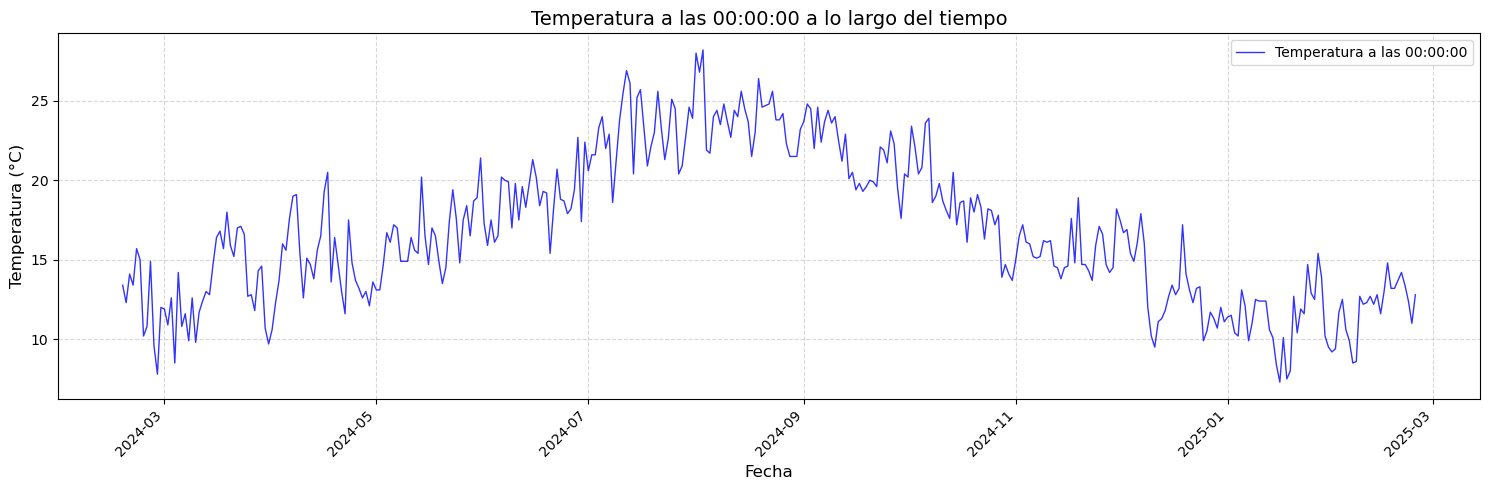

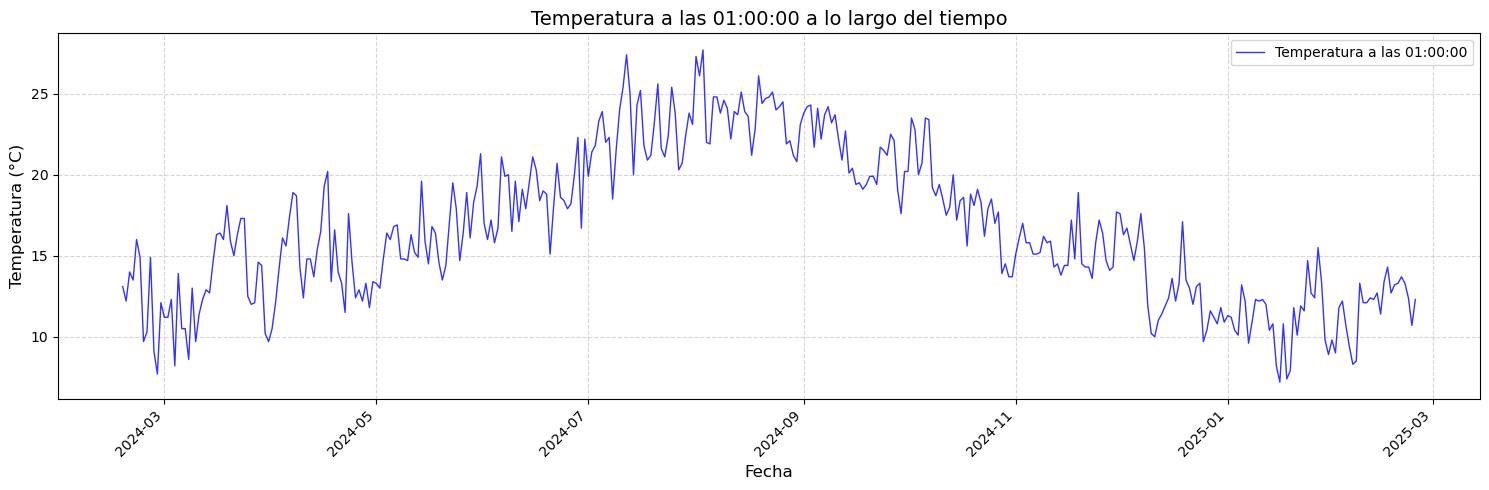

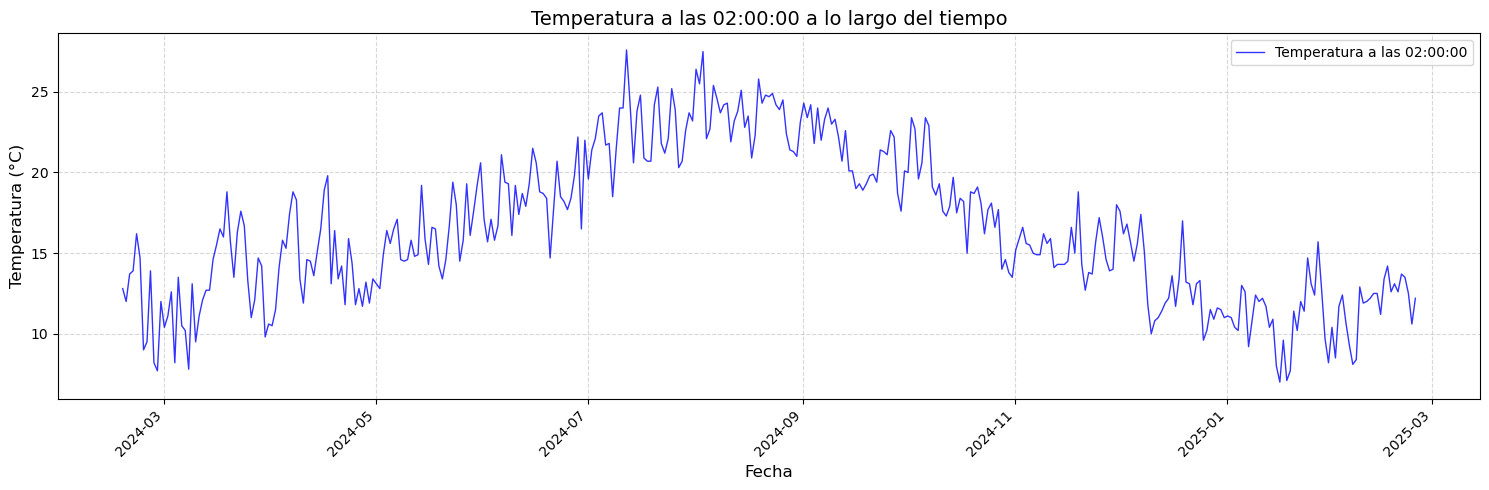

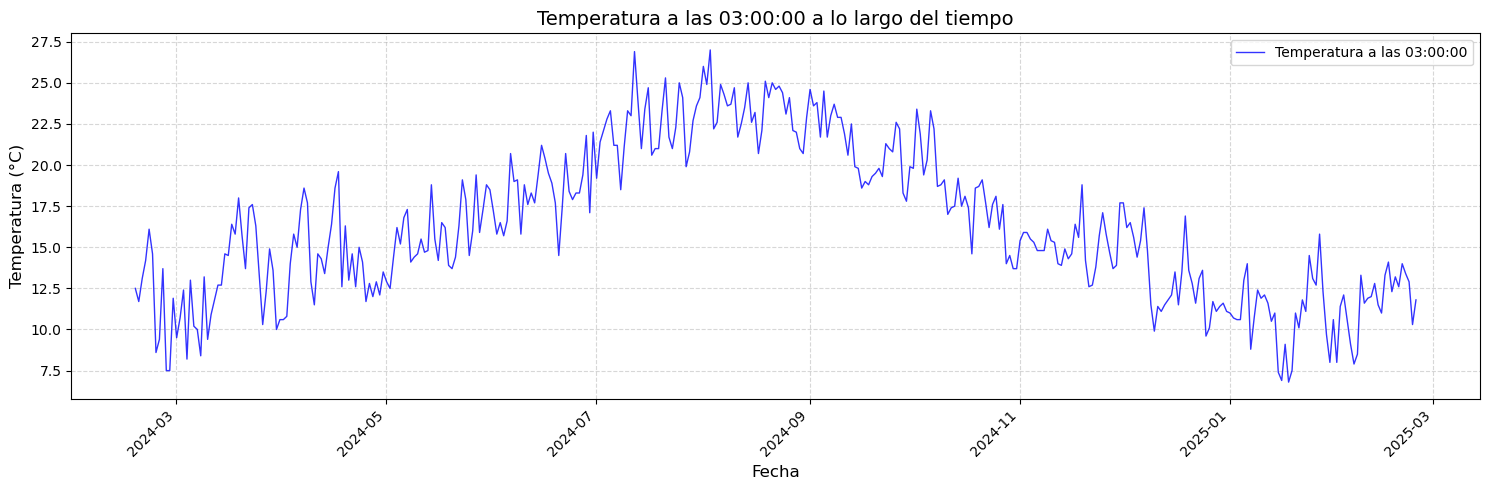

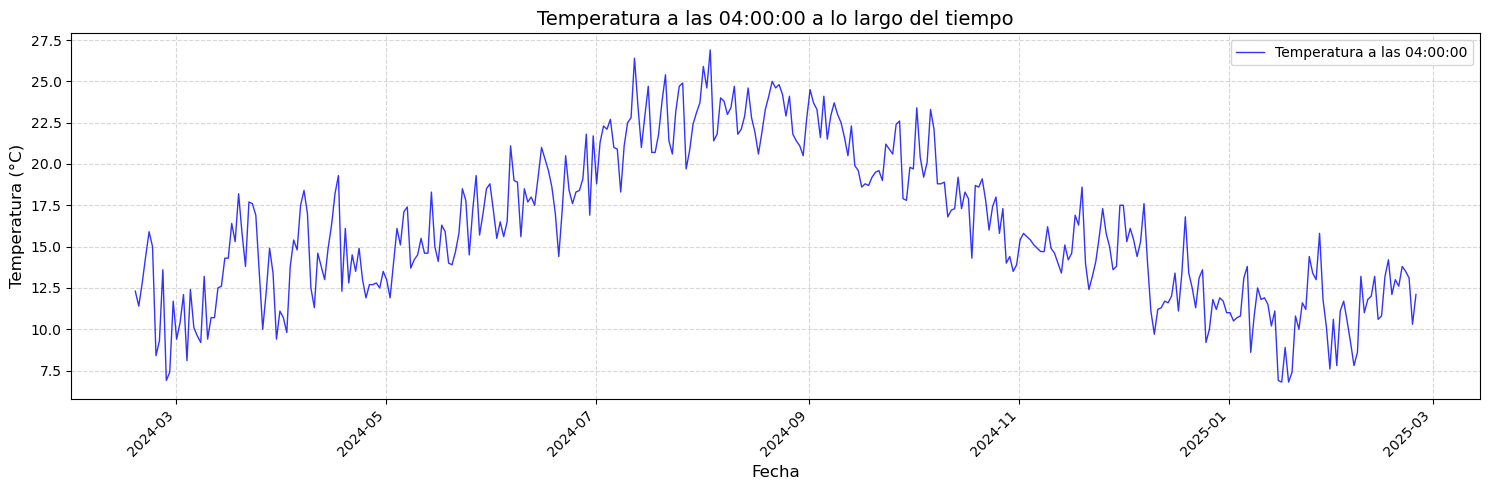

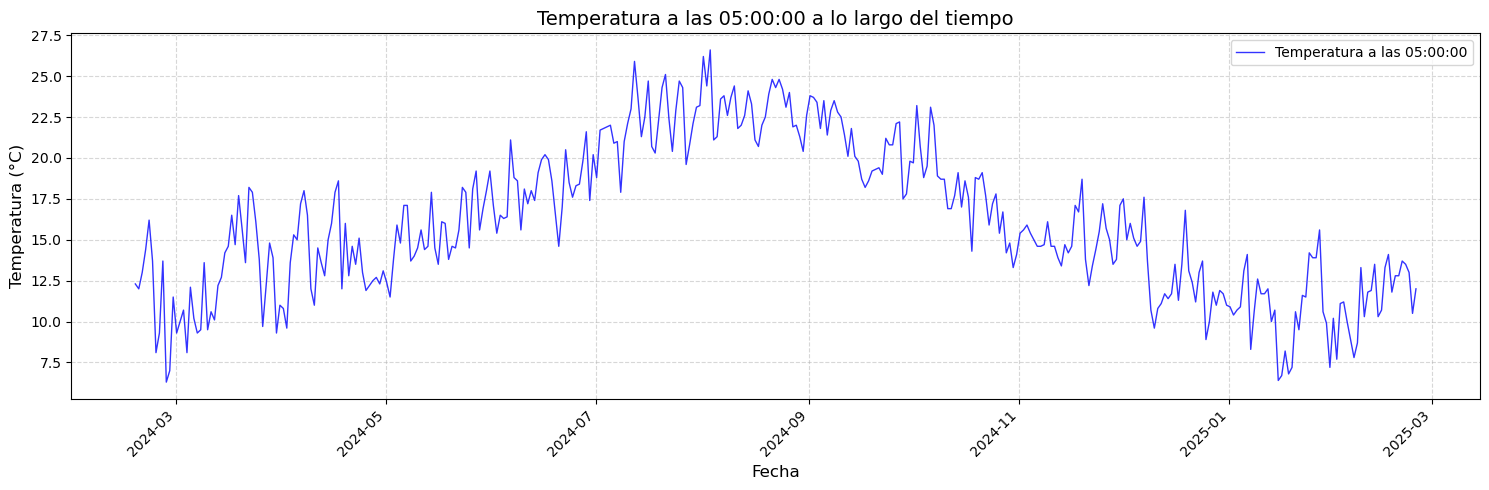

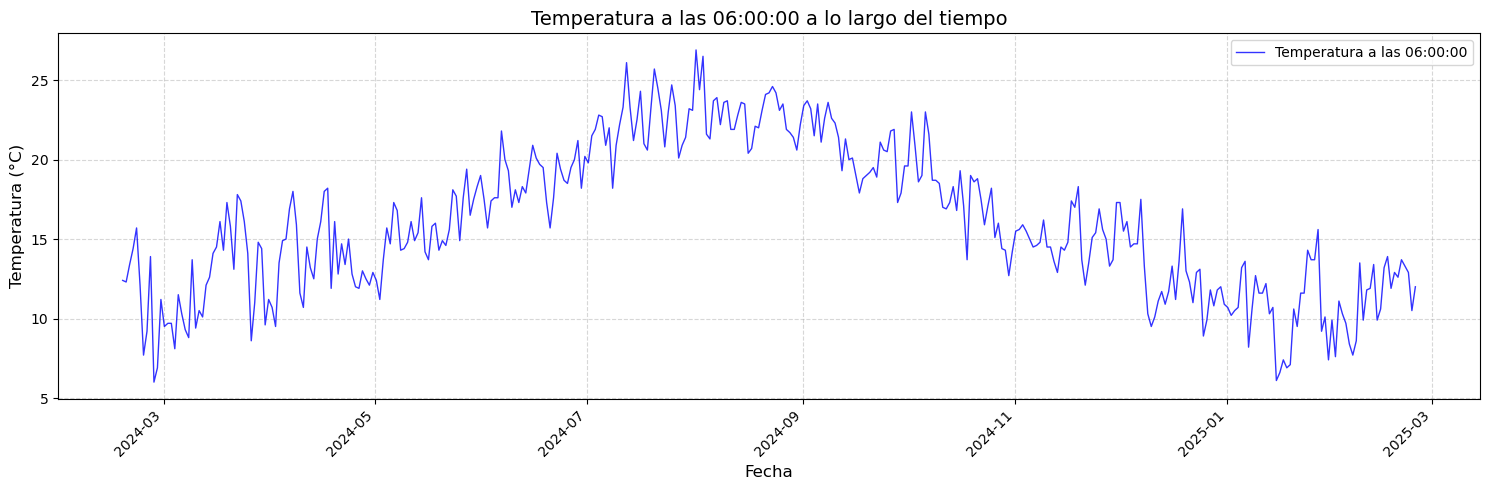

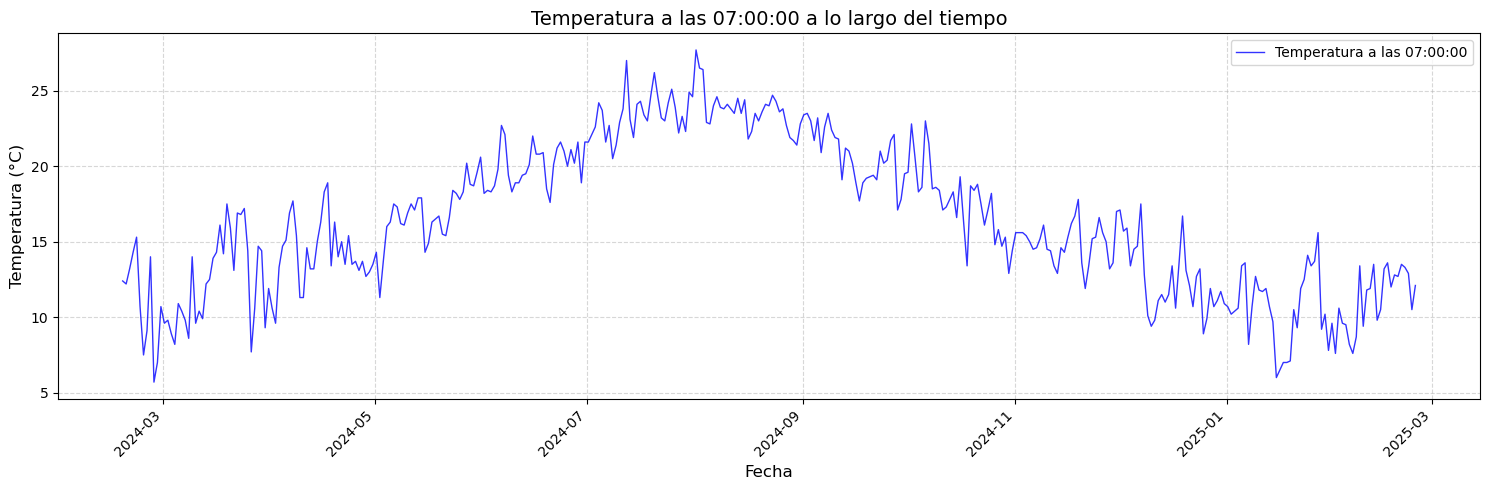

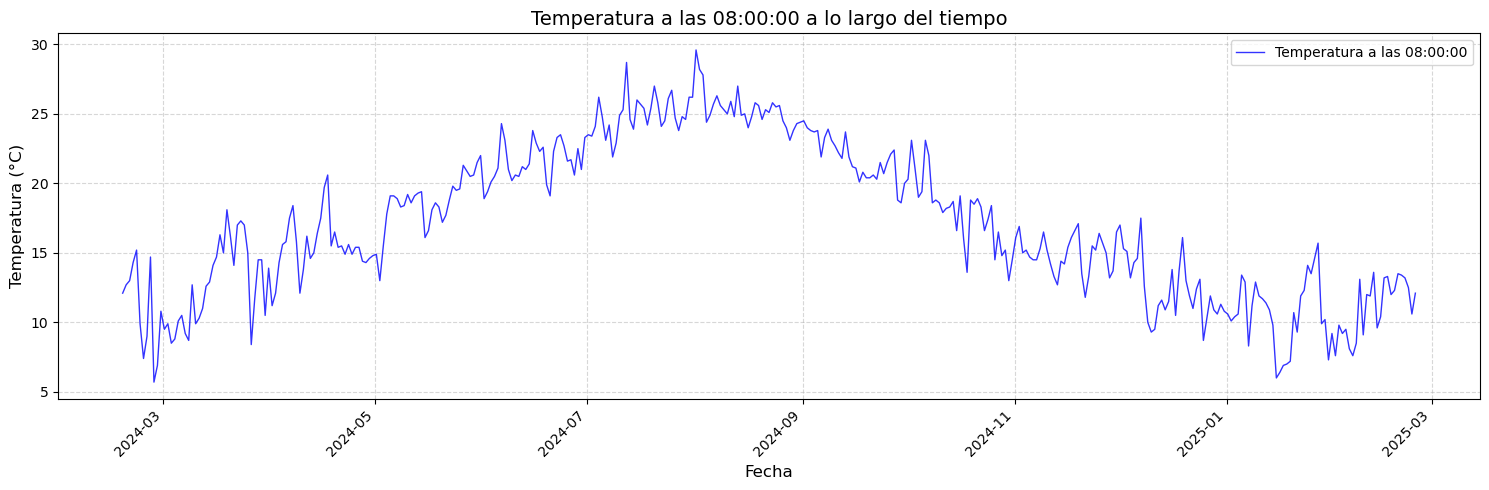

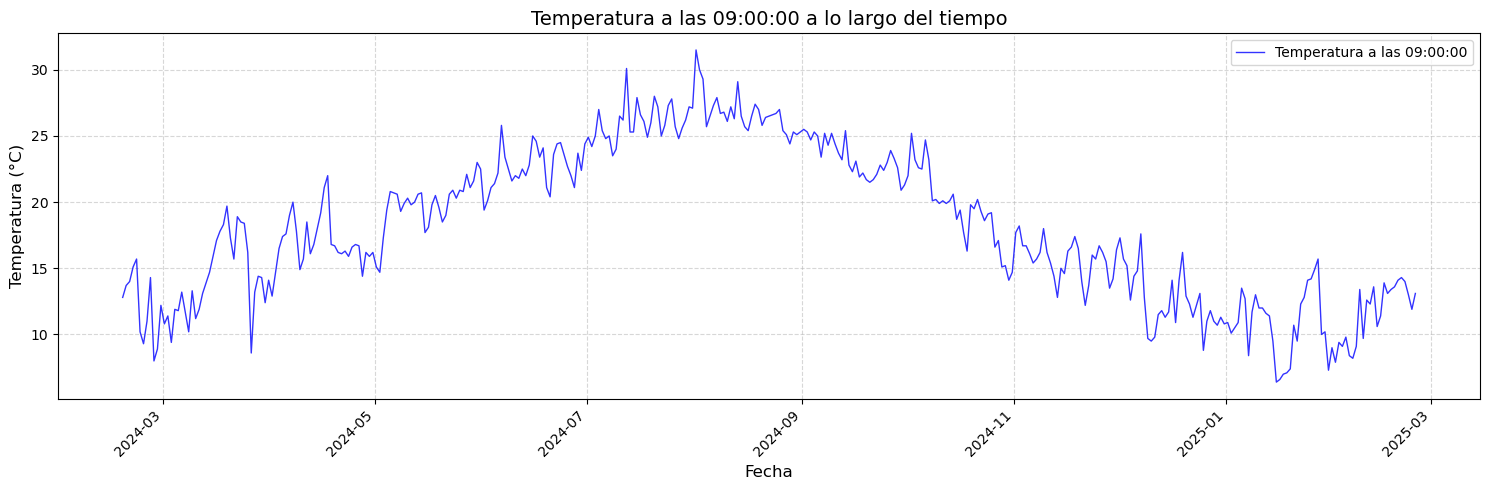

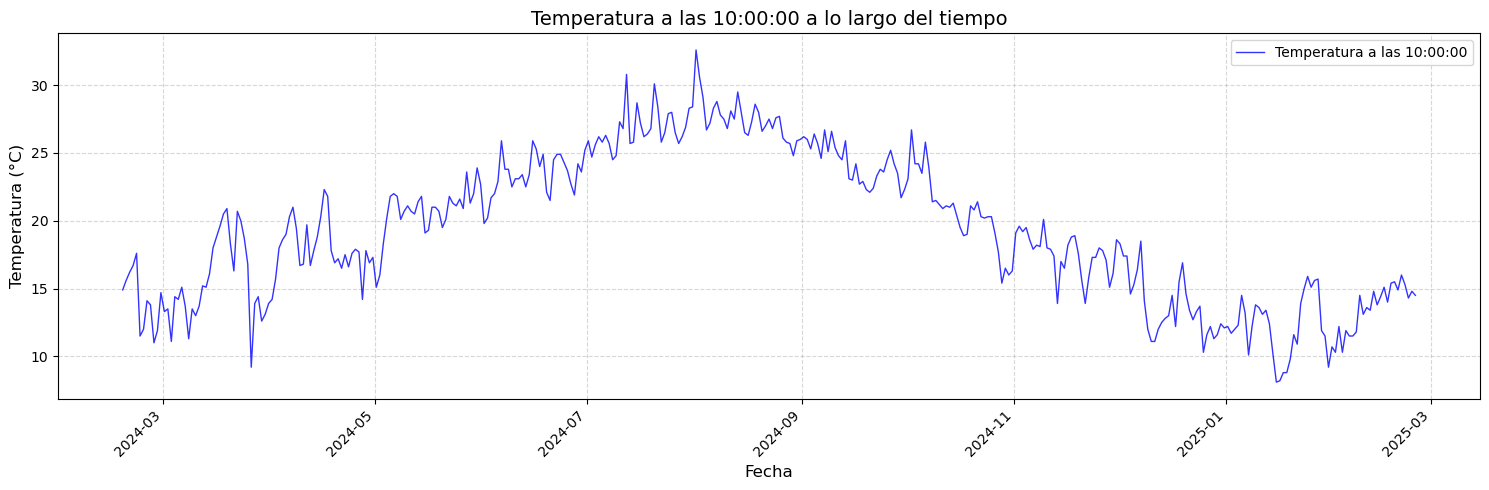

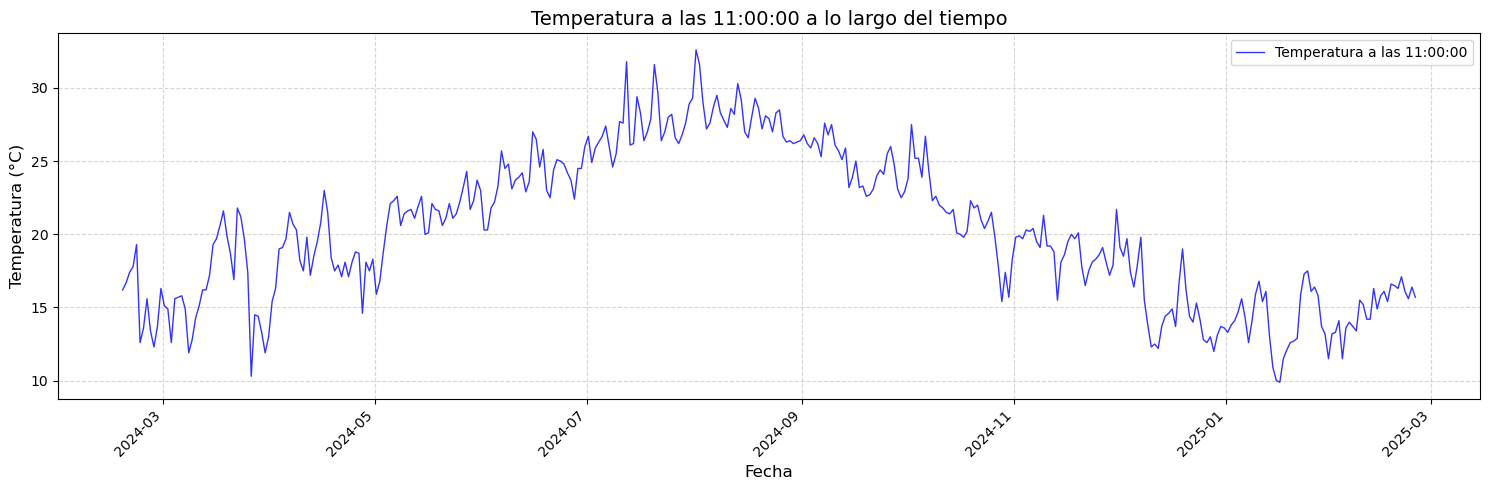

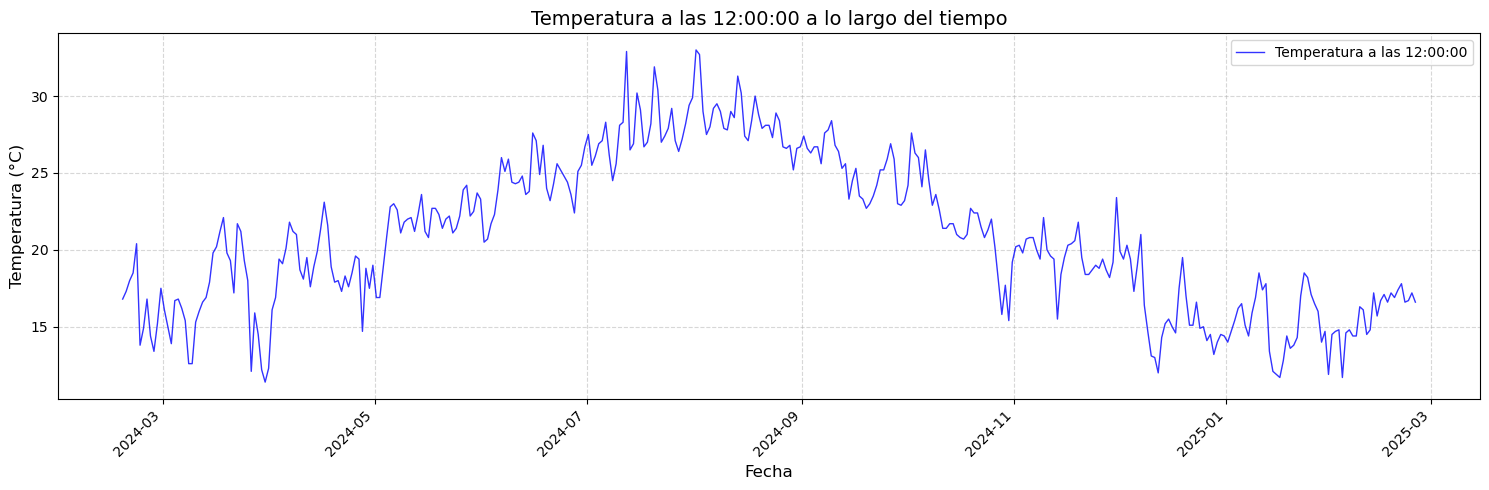

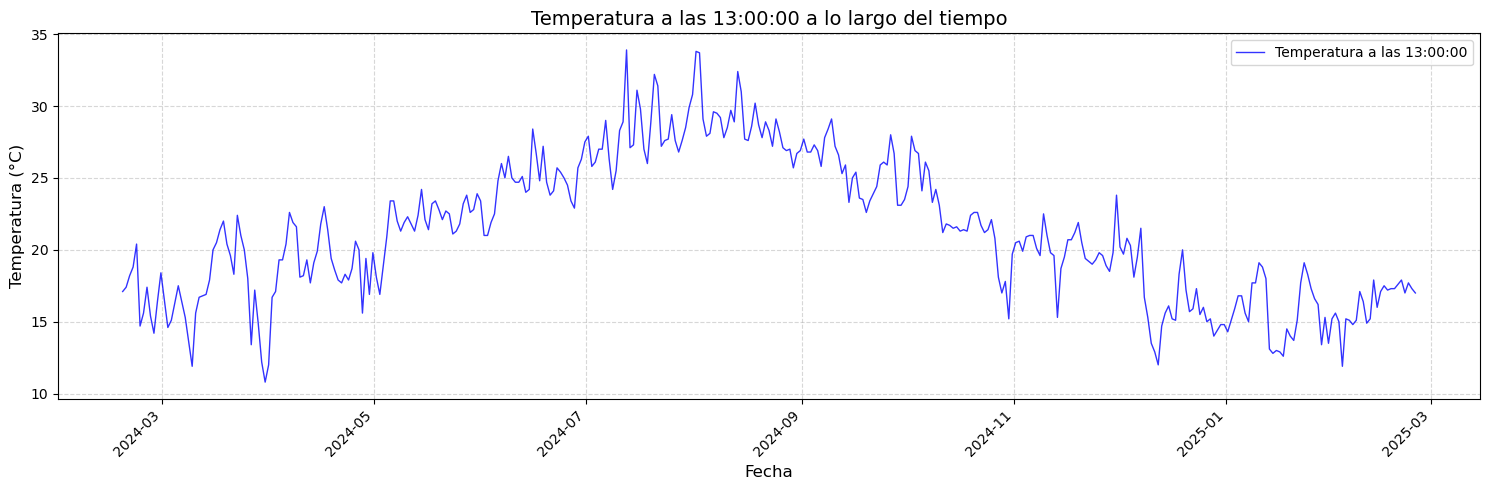

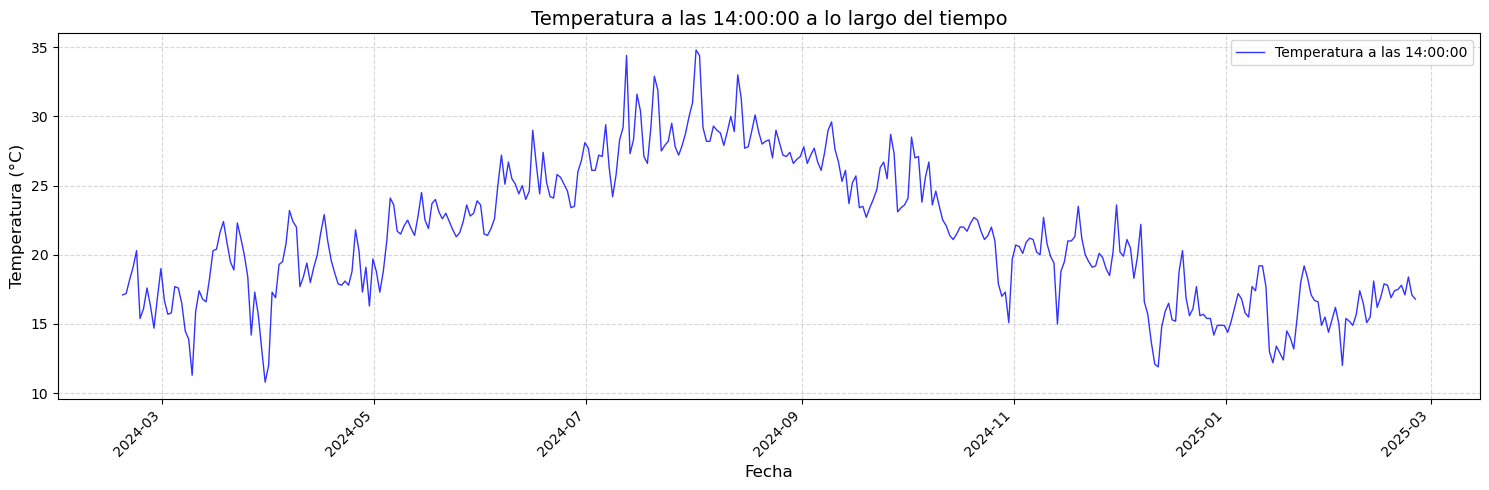

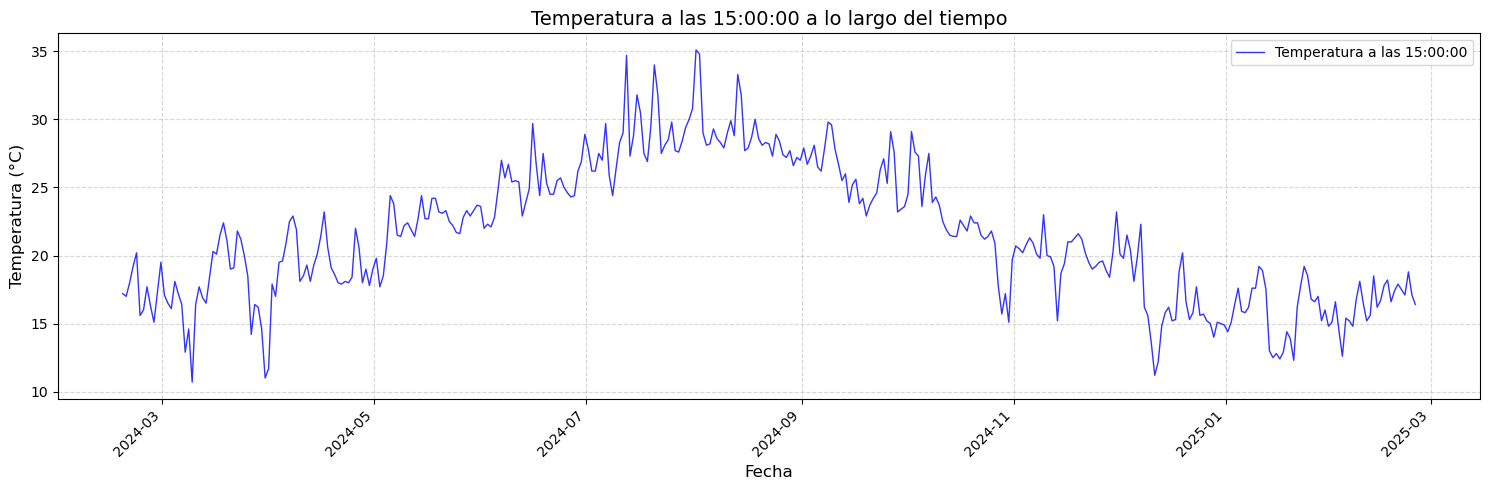

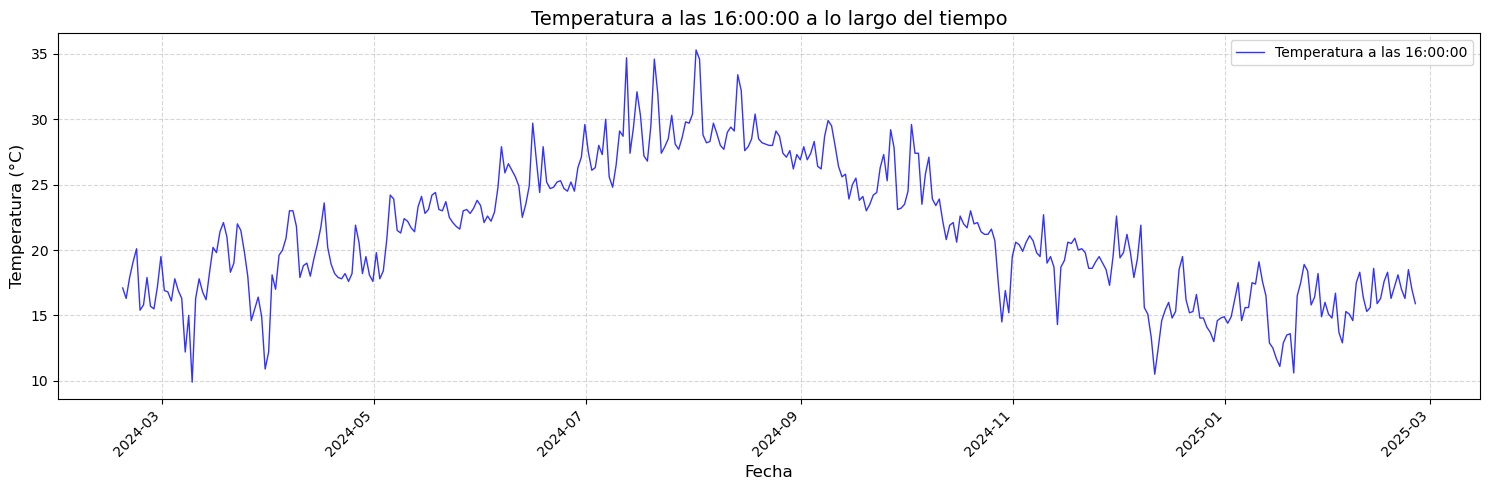

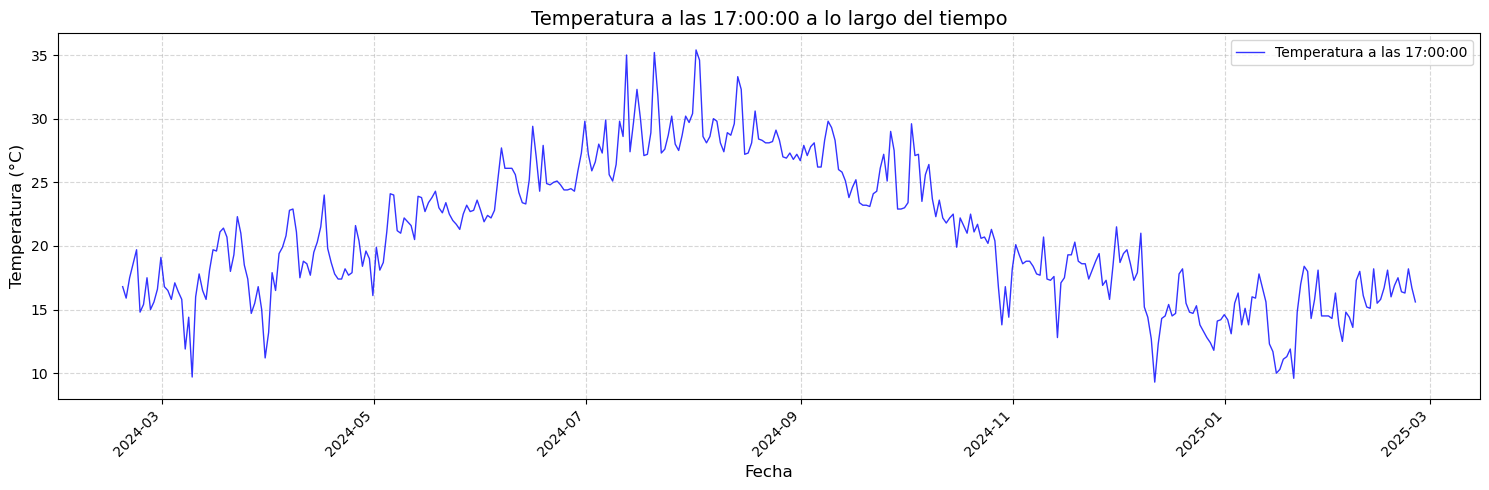

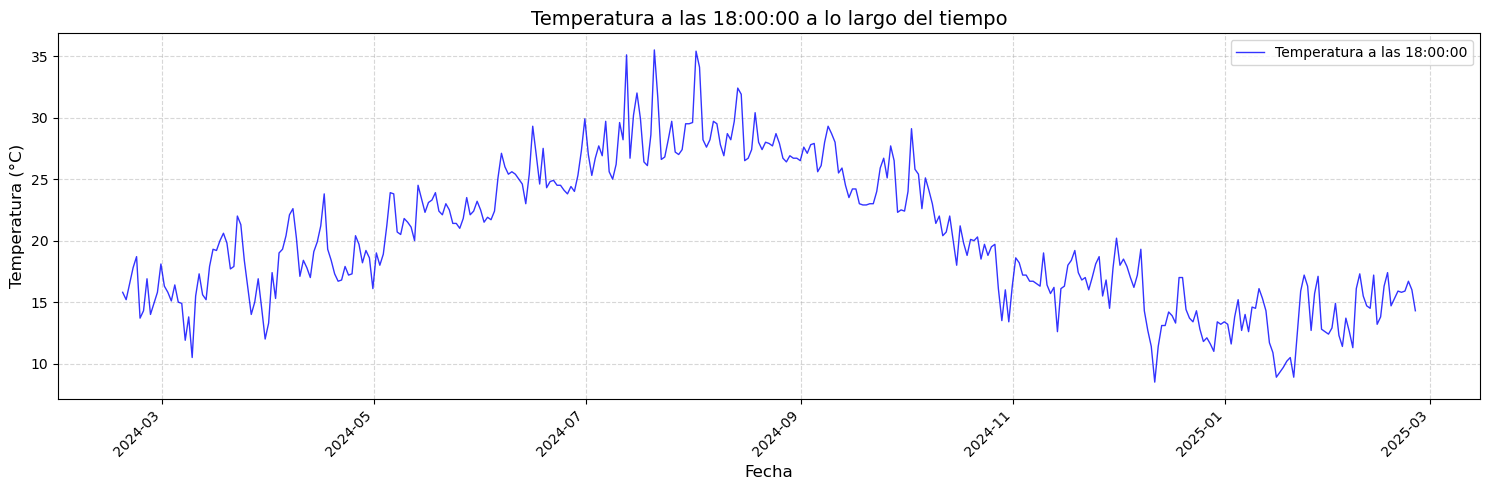

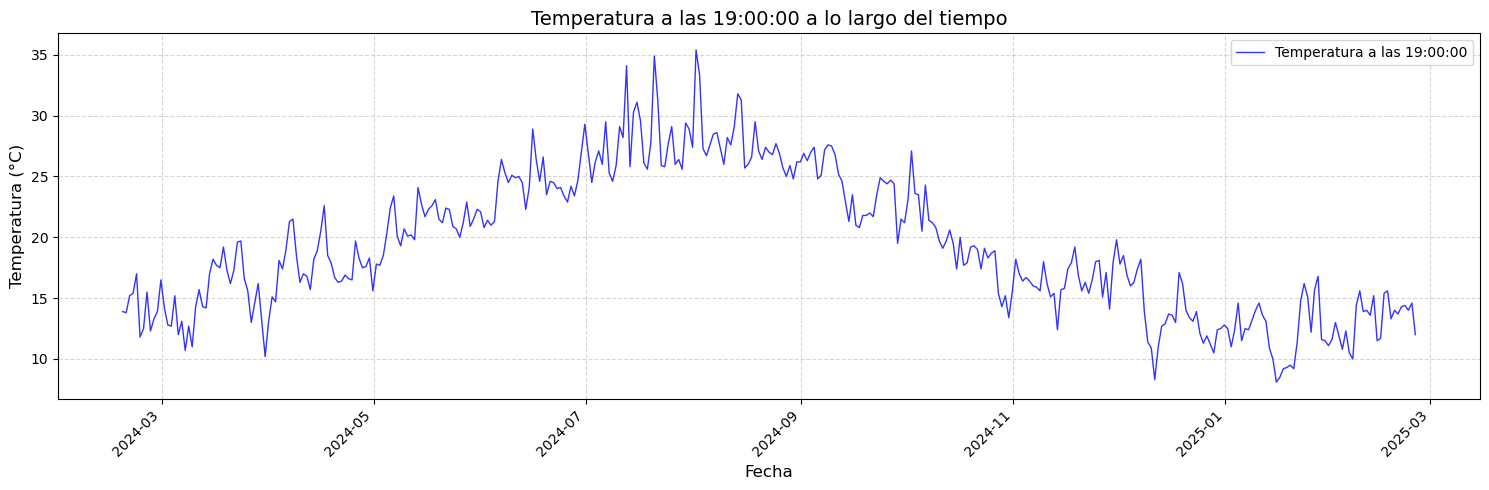

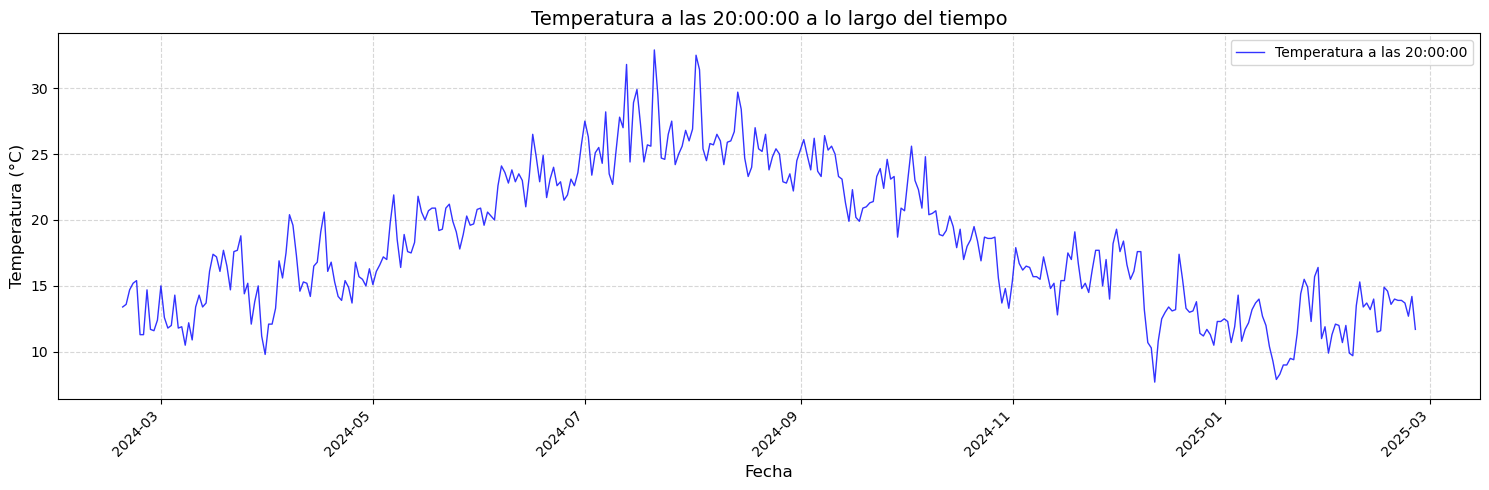

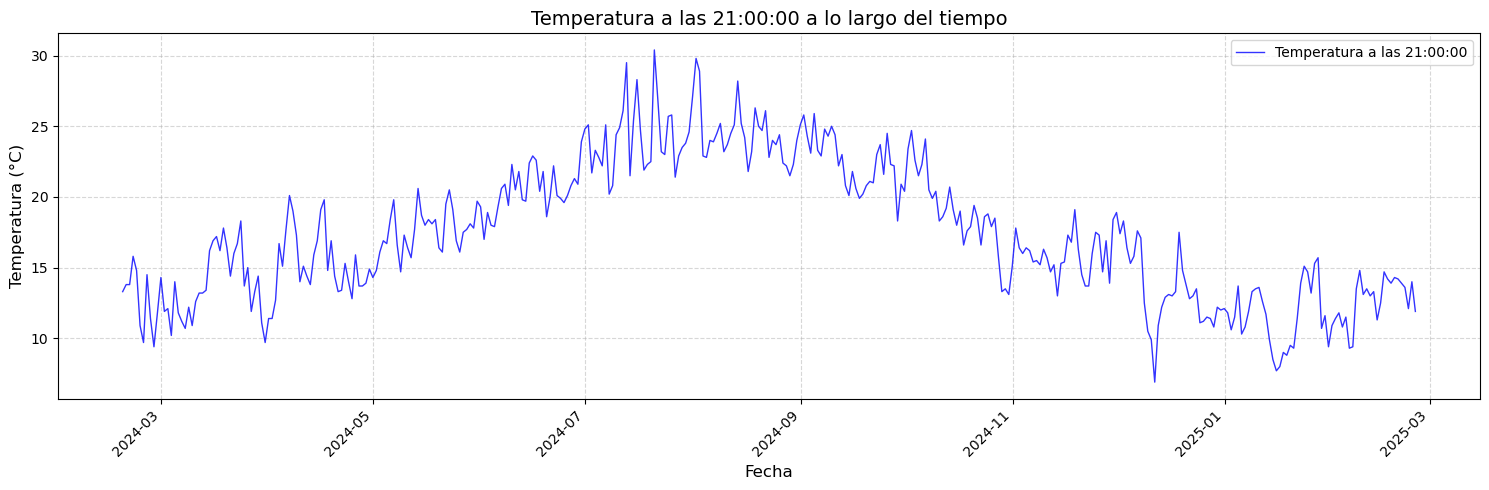

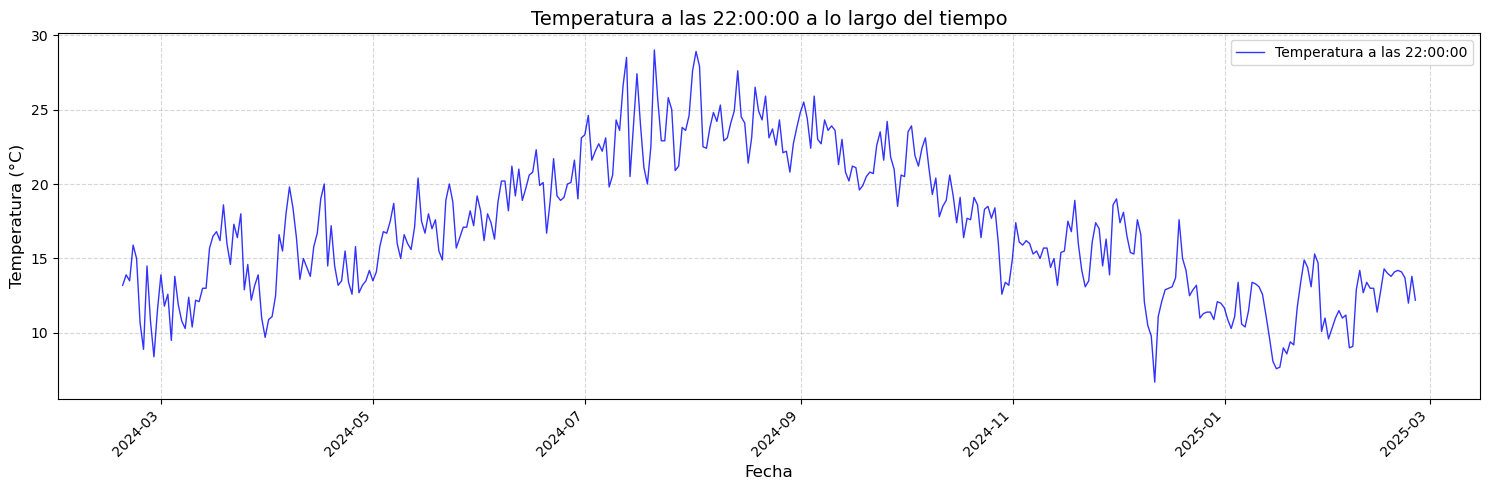

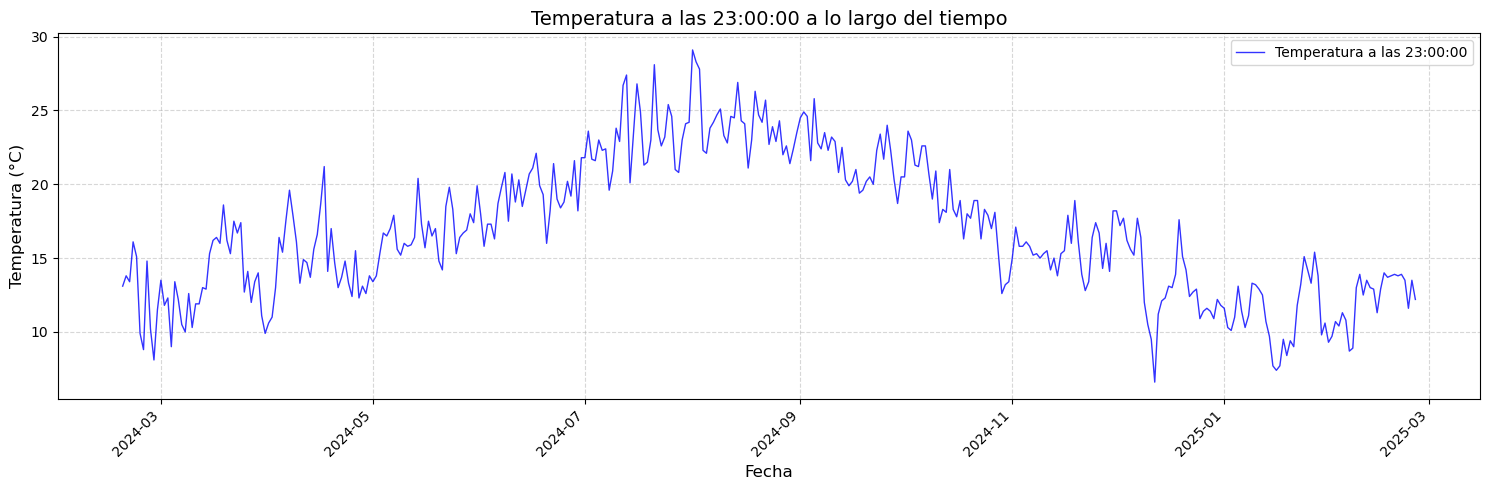

In [10]:
# Convertir la columna 'Fecha' a tipo datetime si no lo está
df_pandas['Fecha'] = pd.to_datetime(df_pandas['Fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='Fecha')

# Extraer la hora de la columna 'Fecha'
df_pandas['Hora'] = df_pandas['Fecha'].dt.hour

# Generar un gráfico para cada hora del día (desde 00:00:00 hasta 23:00:00)
for hora in range(24):  # Las horas van de 0 a 23
    # Filtrar los datos para la hora específica
    df_hora = df_pandas[df_pandas['Hora'] == hora]
    
    plt.figure(figsize=(15, 5))
    
    # Graficar la temperatura para la hora específica
    plt.plot(df_hora['Fecha'], df_hora['Temperatura_C'], linestyle='-', color='b', linewidth=1, alpha=0.8, label=f'Temperatura a las {hora:02d}:00:00')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a las {hora:02d}:00:00 a lo largo del tiempo', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.tight_layout()  # Ajustar el layout para que no se solapen las etiquetas
    plt.show()

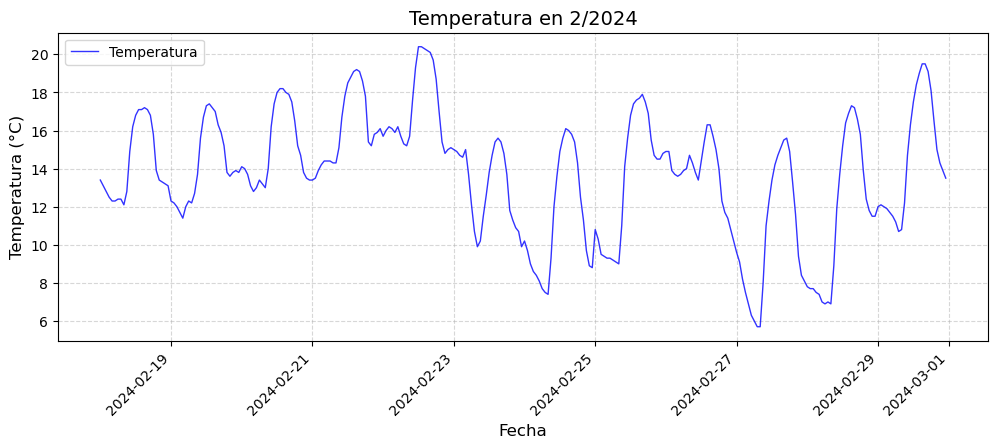

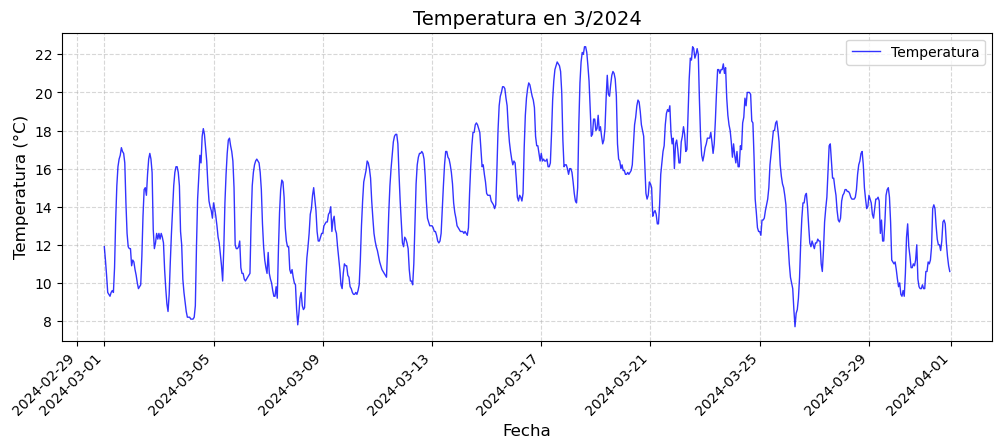

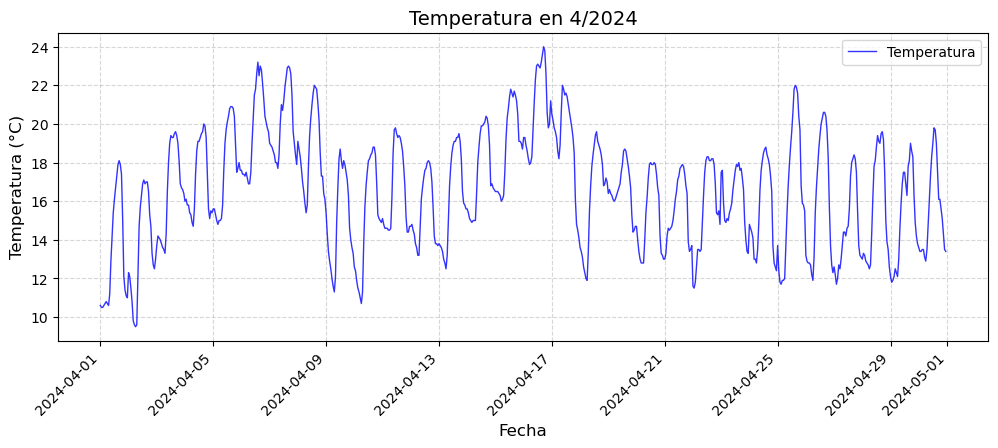

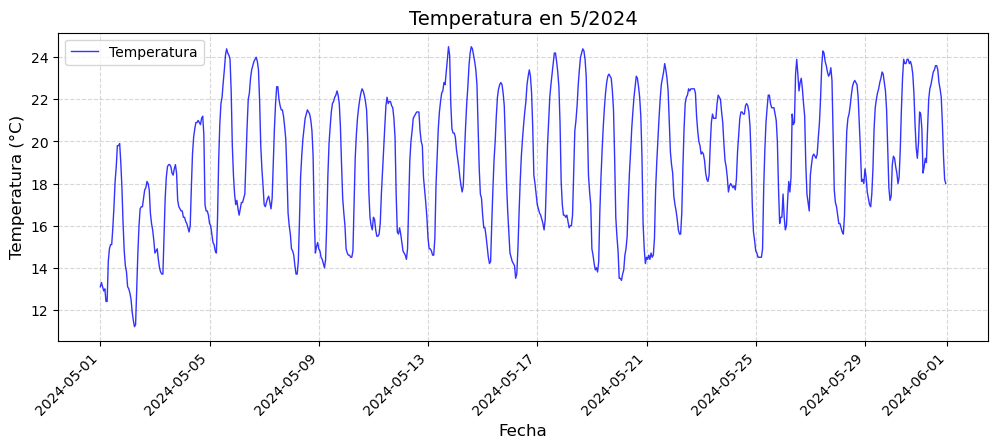

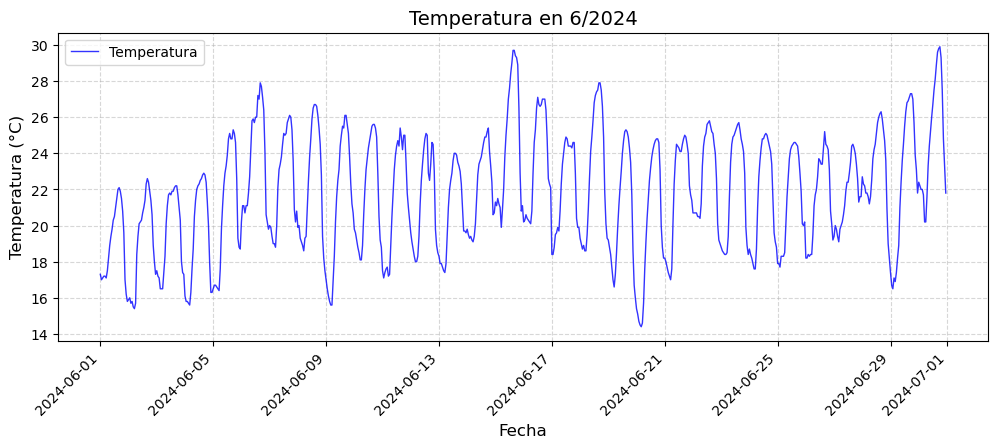

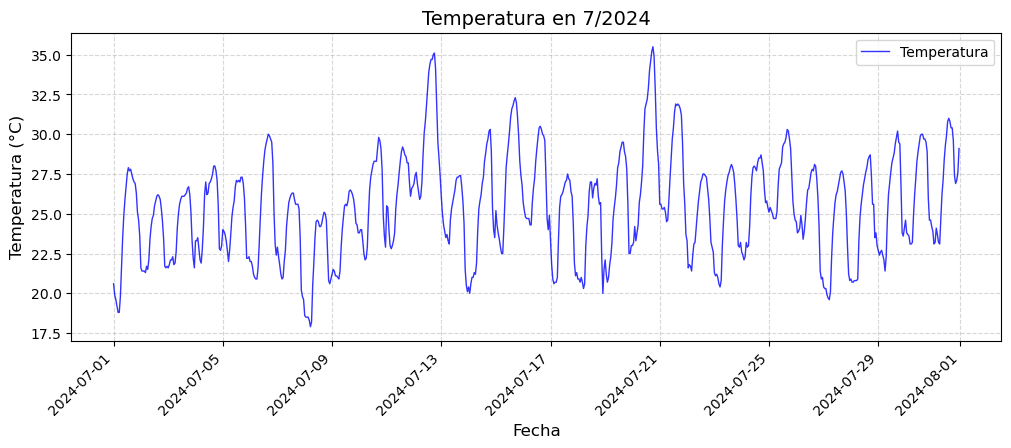

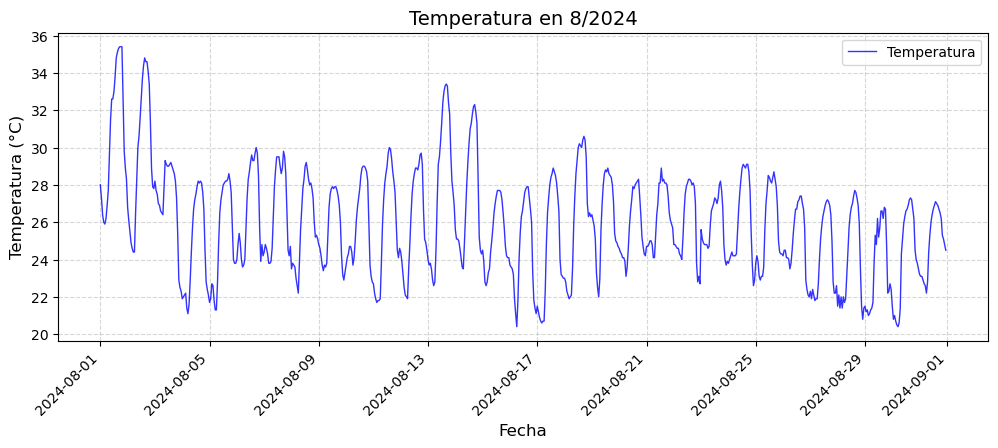

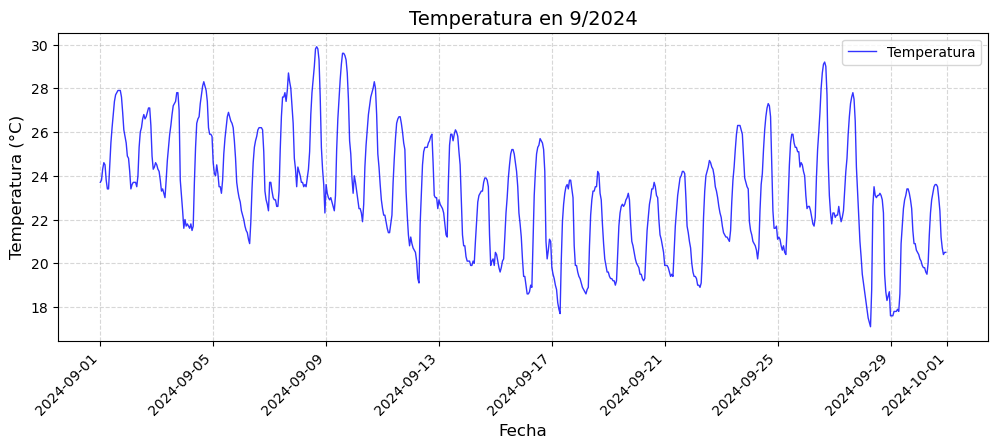

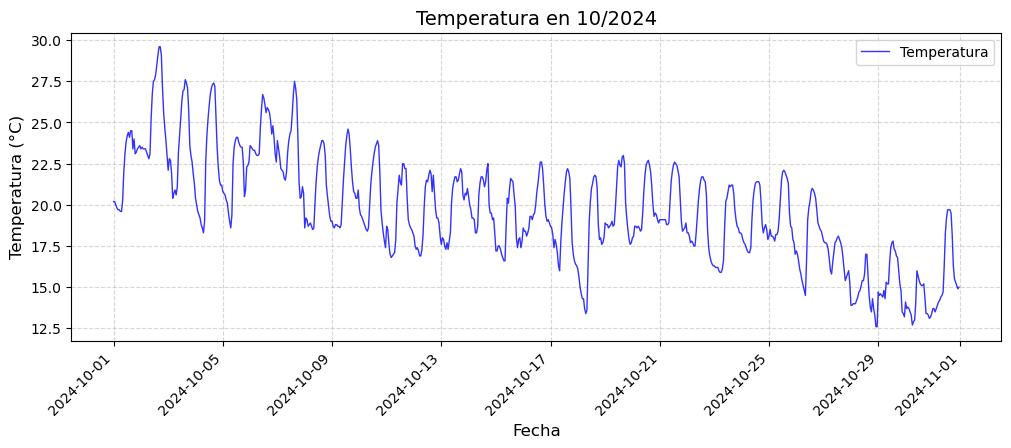

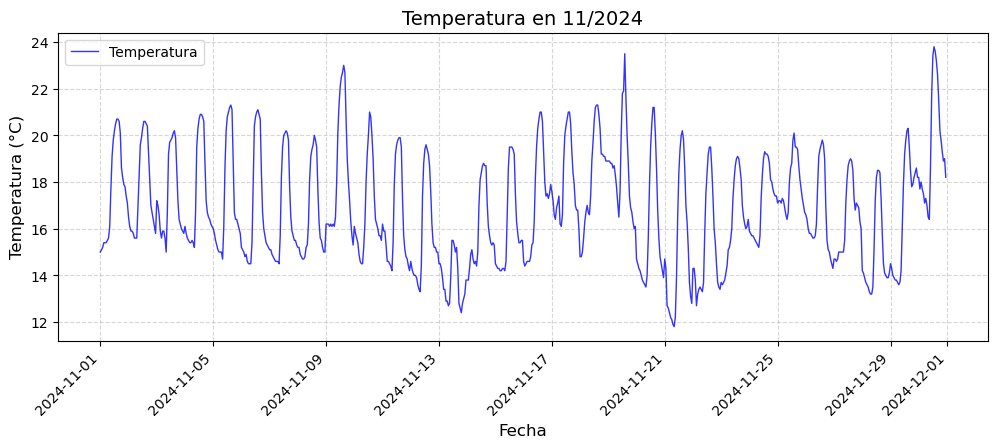

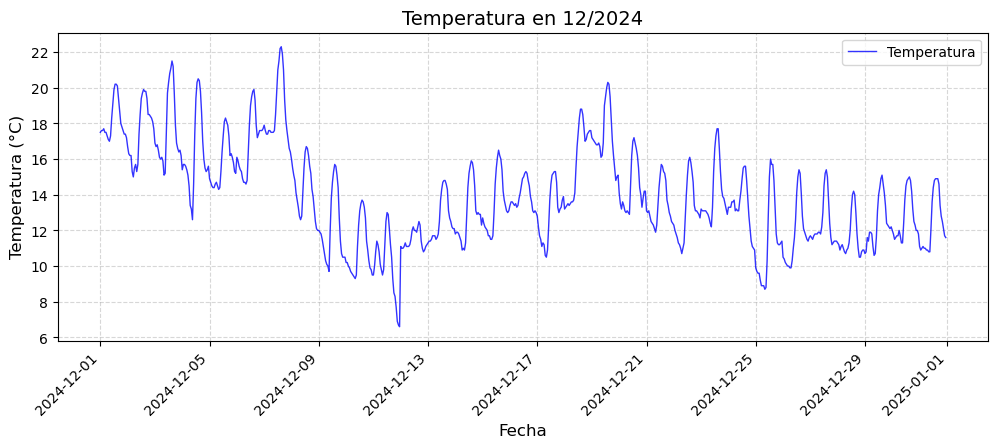

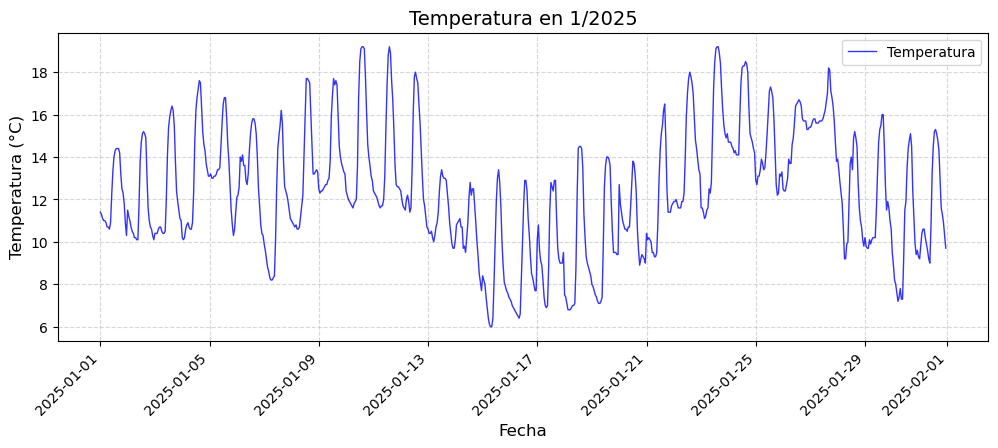

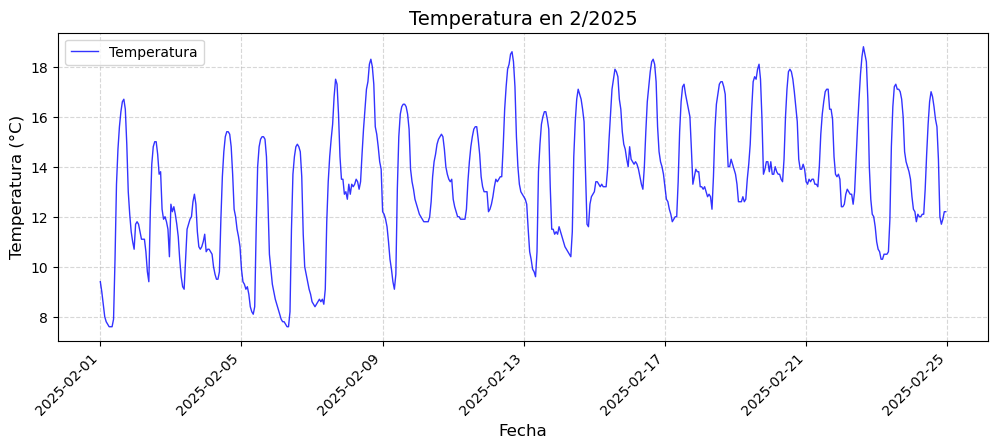

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la columna 'Fecha' a tipo datetime si no lo está
df_pandas['Fecha'] = pd.to_datetime(df_pandas['Fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='Fecha')

# Obtener combinaciones únicas de año y mes
años_meses_unicos = df_pandas[['Fecha']].copy()
años_meses_unicos['Año'] = df_pandas['Fecha'].dt.year
años_meses_unicos['Mes'] = df_pandas['Fecha'].dt.month
años_meses_unicos = años_meses_unicos.drop_duplicates(subset=['Año', 'Mes'])

# Generar un gráfico por cada mes y año
for _, row in años_meses_unicos.iterrows():
    año, mes = row['Año'], row['Mes']
    df_mensual = df_pandas[(df_pandas['Fecha'].dt.year == año) & (df_pandas['Fecha'].dt.month == mes)]
    
    plt.figure(figsize=(12, 4))
    plt.plot(df_mensual['Fecha'], df_mensual['Temperatura_C'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='Temperatura')

    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura en {mes}/{año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()


Descomposicion de la serie temporal por sus componentes

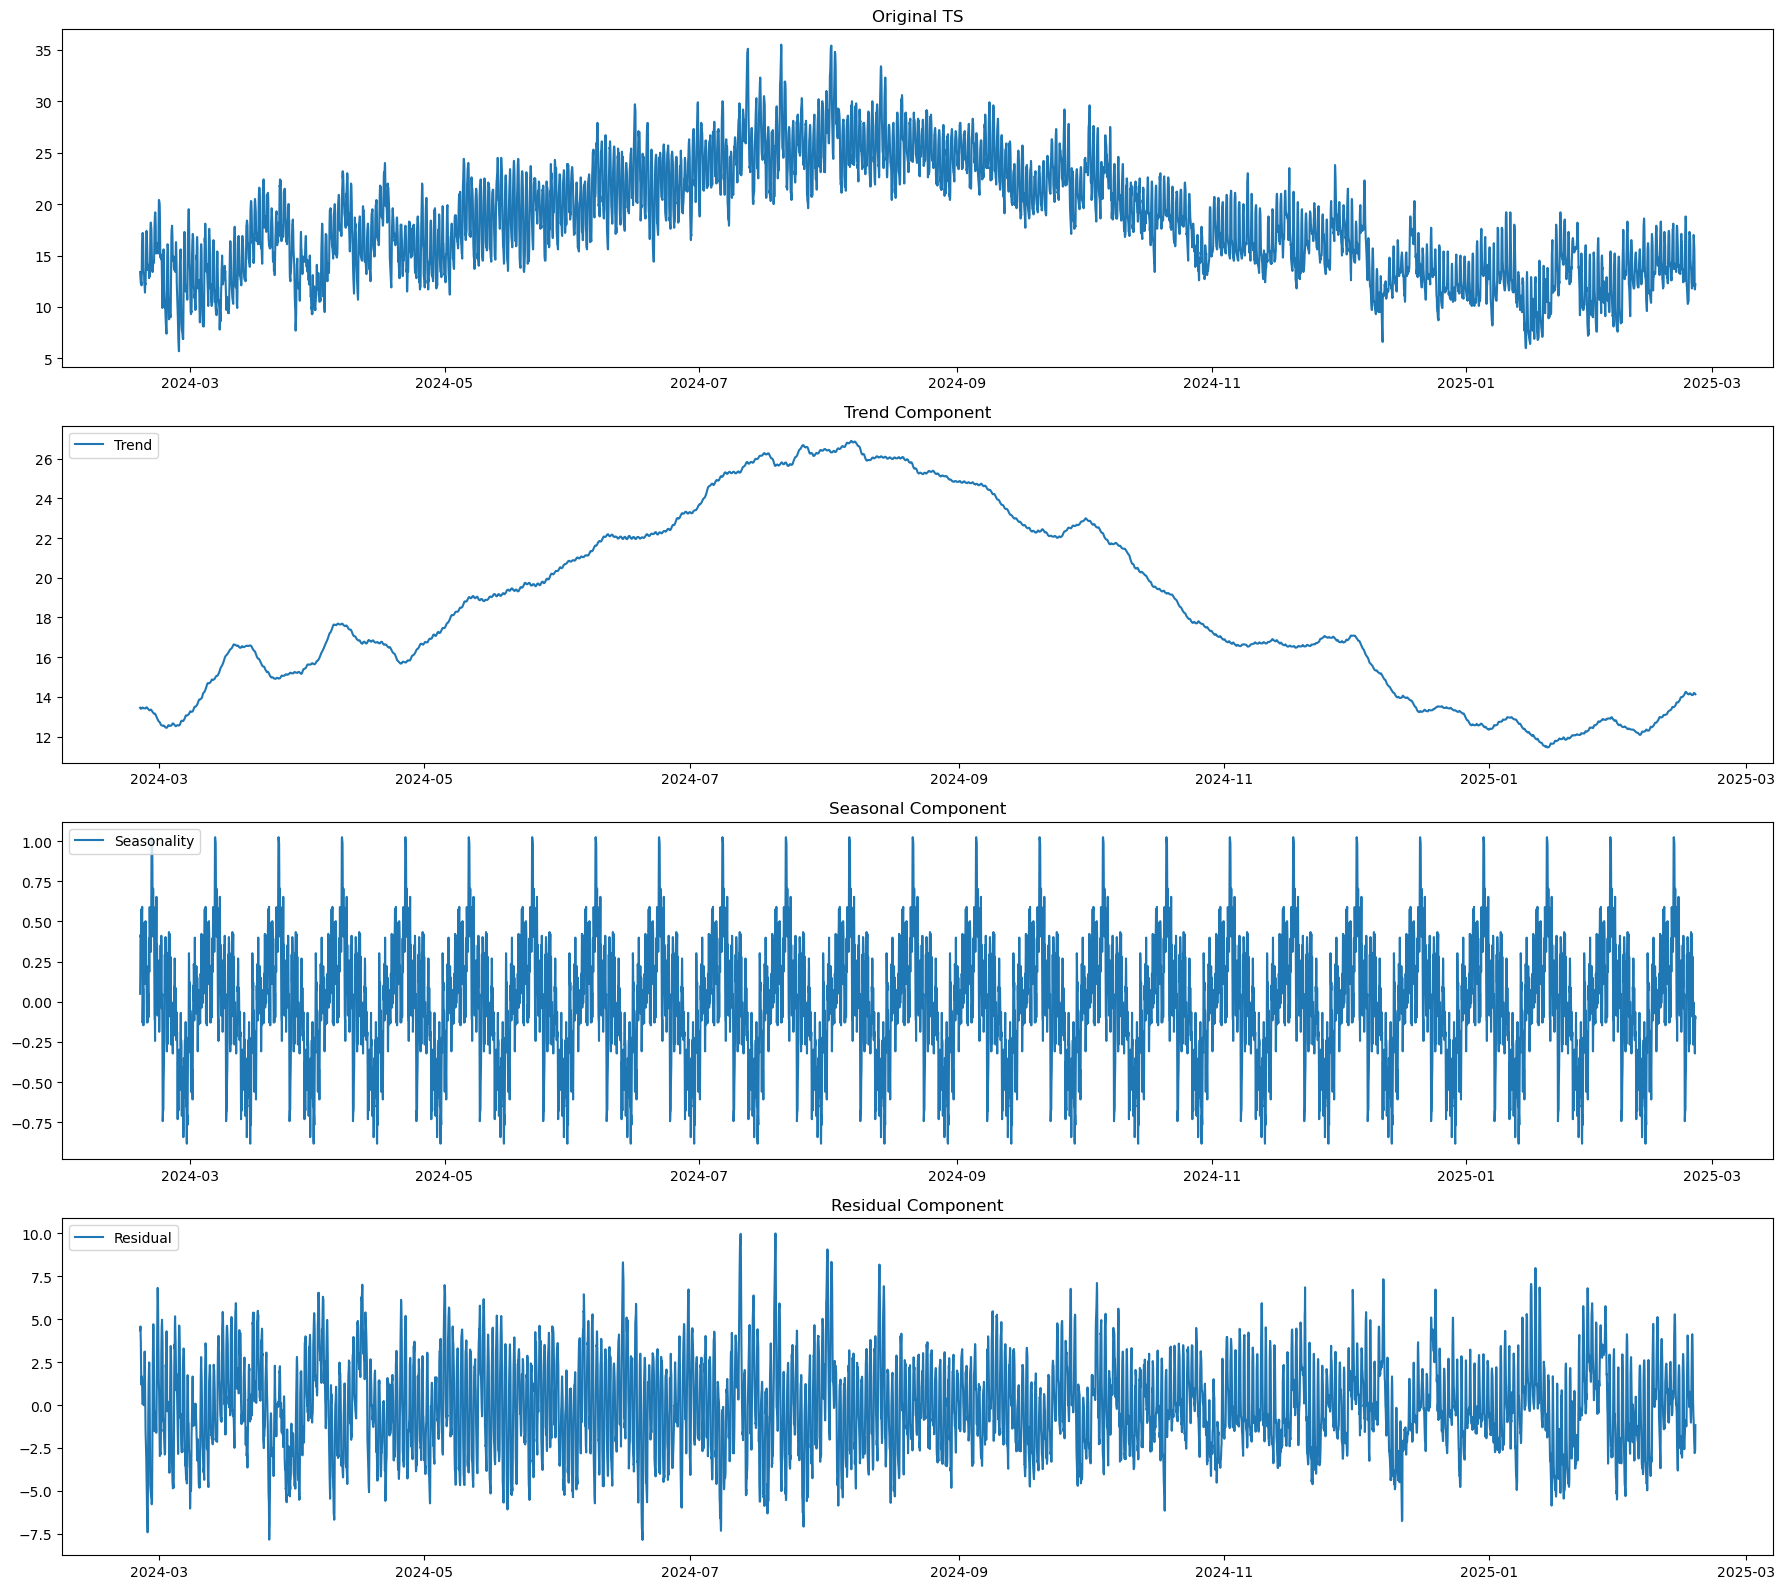

In [20]:
# Decompose the Air Passengers dataset to show trend, seasonality, and residuals
decomposition_air = seasonal_decompose(df_pandas['Temperatura_C'], model='additive', period=365)

# Plot the decomposed components for Air Passengers
plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df_pandas["Fecha"], df_pandas["Temperatura_C"])
plt.title('Original TS')

plt.subplot(4, 1, 2)
plt.plot(df_pandas["Fecha"], decomposition_air.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(df_pandas["Fecha"], decomposition_air.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(df_pandas["Fecha"], decomposition_air.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Comprobamos si la serie es estacionaria

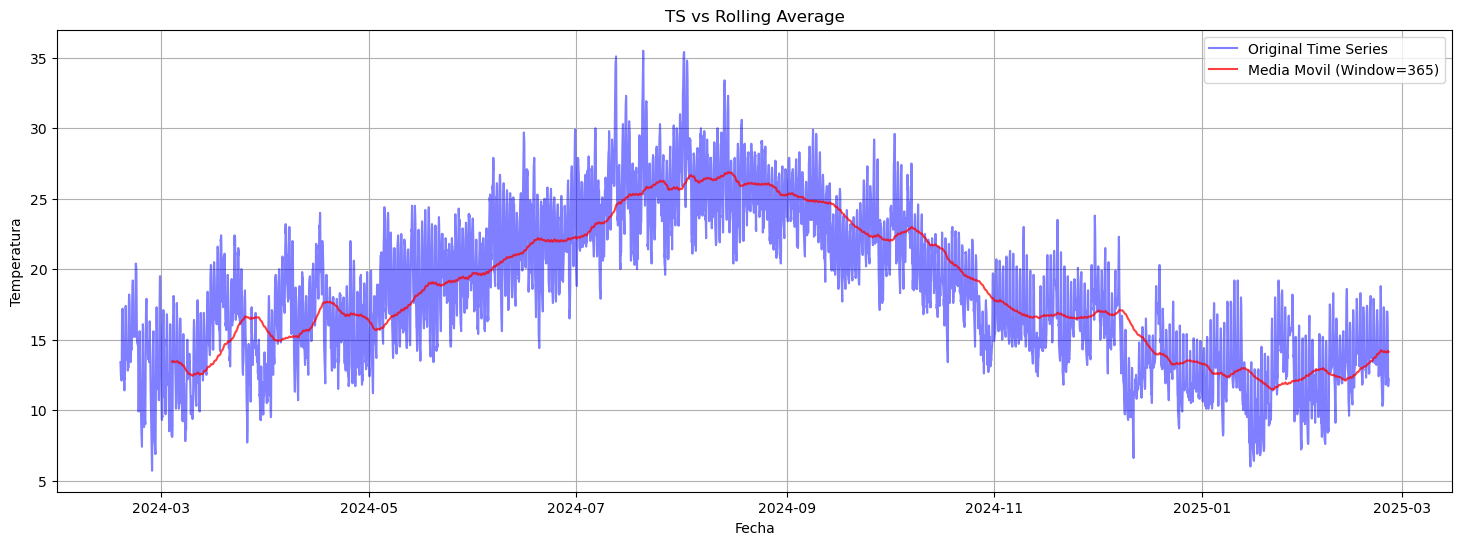

In [22]:
window_size = 365

df_pandas['MA'] = df_pandas["Temperatura_C"].rolling(window=window_size).mean()

plt.figure(figsize=(18, 6))

plt.plot(df_pandas["Fecha"], df_pandas['Temperatura_C'], label='Original Time Series', color='blue', alpha=0.5)
plt.plot(df_pandas["Fecha"], df_pandas['MA'], label=f'Media Movil (Window={window_size})', color='red', alpha=0.75)

plt.title('TS vs Rolling Average')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

Realizamos el test ADF (Augmented Dickey-Fuller) para comprobar si la serie es estacionaria

In [23]:
def check_stationarity(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

In [25]:
check_stationarity(df['Temperatura_C'], 'Temperatura')

ADF Statistic for Temperatura: -3.484236607331366
p-value: 0.008401281377047182
The series is likely stationary.


Como resultado del test de Dickey-Fuller, observamos que la serie temporal no es estacionaria

##### Deteccion de outliers

In [26]:
from scipy.stats import median_abs_deviation

##### Filtro Hampel (with centered window)

El filtro Hampel es un método utilizado para detectar y eliminar valores atípicos en series temporales. Este filtro es una variación de la regla de tres sigmas en estadística que es robusta frente a valores atípicos.
Funciona calculando la mediana de una ventana que incluye la muestra actual y sus vecinos, generalmente tres muestras por lado.

In [39]:
window_size=48
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df_pandas["Temperatura_C"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df_pandas["Temperatura_C"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df_pandas["outlier_hm"] = (np.abs(df_pandas["Temperatura_C"] - rolling_median) > n_sigma*mad)

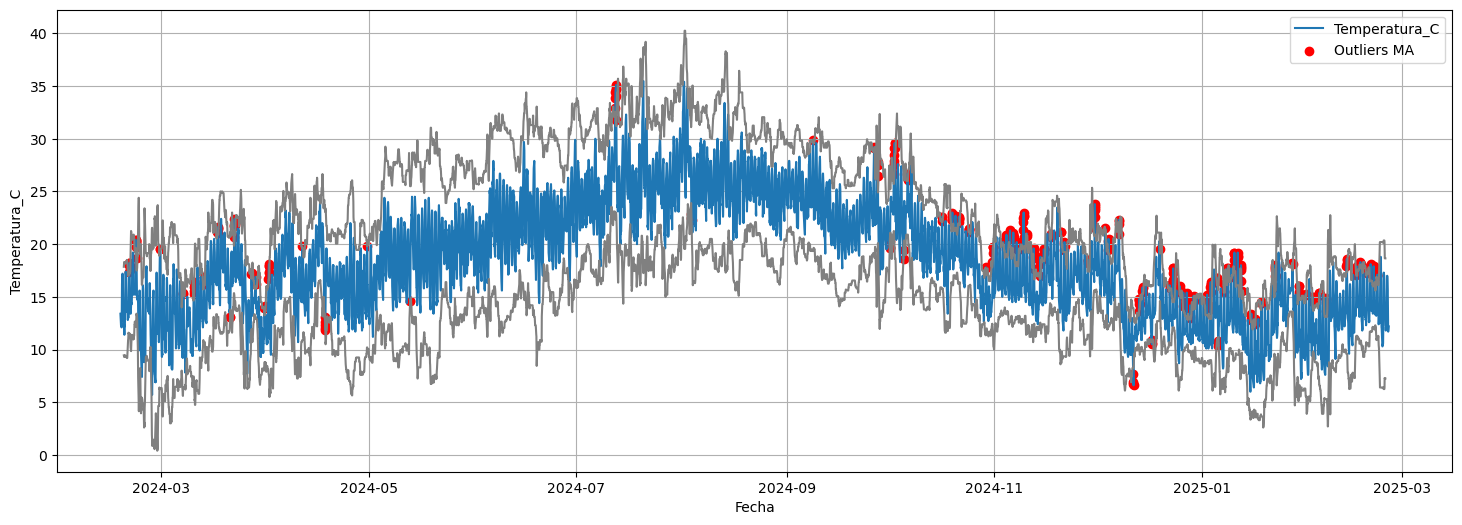

In [40]:
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['Fecha'], df_pandas['Temperatura_C'], label='Temperatura_C')
plt.plot(df_pandas['Fecha'], threshold_min, color='gray')
plt.plot(df_pandas['Fecha'], threshold_max, color='gray')
plt.scatter(df_pandas["Fecha"][df_pandas["outlier_hm"]], df_pandas["Temperatura_C"][df_pandas["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Fecha')
plt.ylabel('Temperatura_C')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
# Convertir la columna 'Fecha' a datetime si no lo está
df_pandas['Fecha'] = pd.to_datetime(df_pandas['Fecha'])

# Extraer año y mes para agrupar los datos
df_pandas['AñoMes'] = df_pandas['Fecha'].dt.to_period('M')

# Iterar sobre cada año-mes único y graficar
for period, df_group in df_pandas.groupby('AñoMes'):
    plt.figure(figsize=(18, 6))
    
    plt.plot(df_group['Fecha'], df_group['Temperatura_C'], label='Temperatura_C')
    plt.plot(df_group['Fecha'], threshold_min[df_group.index], color='gray', label='Threshold Min')
    plt.plot(df_group['Fecha'], threshold_max[df_group.index], color='gray', label='Threshold Max')
    plt.scatter(df_group["Fecha"][df_group["outlier_hm"]], df_group["Temperatura_C"][df_group["outlier_hm"]], color='red', label="Outliers MA")
    
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura_C')
    plt.title(f'Temperatura en {period}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


NameError: name 'pd' is not defined

Tratamiento de los datos outliers por el valor mas cercano (limite superior o limite inferior segun sea necesario)

In [43]:
df_pandas[df_pandas["outlier_hm"]==True].head()

Fecha  Temperatura_C  Sensacion_termica_C  Humedad  \
59 2024-02-20 11:00:00           17.4                 17.4       54   
60 2024-02-20 12:00:00           18.0                 18.0       52   
61 2024-02-20 13:00:00           18.2                 18.2       53   
62 2024-02-20 14:00:00           18.2                 18.2       54   
63 2024-02-20 15:00:00           18.0                 18.0       57   

    Presion_mb  is_day  Hora  MA  outlier_hm   Año  Mes   AñoMes  
59      1030.0       1    11 NaN        True  2024    2  2024-02  
60      1029.0       1    12 NaN        True  2024    2  2024-02  
61      1029.0       1    13 NaN        True  2024    2  2024-02  
62      1028.0       1    14 NaN        True  2024    2  2024-02  
63      1027.0       1    15 NaN        True  2024    2  2024-02

In [47]:
# Sustituir los outliers por el valor más cercano dentro del rango
df_pandas["t_corrected"] = df_pandas["Temperatura_C"].copy()
df_pandas.loc[df_pandas["Temperatura_C"] < threshold_min, "t_corrected"] = threshold_min
df_pandas.loc[df_pandas["Temperatura_C"] > threshold_max, "t_corrected"] = threshold_max

In [50]:
df_pandas[df_pandas["outlier_hm"]==True].head()

Fecha  Temperatura_C  Sensacion_termica_C  Humedad  \
59 2024-02-20 11:00:00           17.4                 17.4       54   
60 2024-02-20 12:00:00           18.0                 18.0       52   
61 2024-02-20 13:00:00           18.2                 18.2       53   
62 2024-02-20 14:00:00           18.2                 18.2       54   
63 2024-02-20 15:00:00           18.0                 18.0       57   

    Presion_mb  is_day  Hora  MA  outlier_hm   Año  Mes   AñoMes  t_corrected  
59      1030.0       1    11 NaN        True  2024    2  2024-02         17.2  
60      1029.0       1    12 NaN        True  2024    2  2024-02         17.2  
61      1029.0       1    13 NaN        True  2024    2  2024-02         17.2  
62      1028.0       1    14 NaN        True  2024    2  2024-02         17.2  
63      1027.0       1    15 NaN        True  2024    2  2024-02         17.2

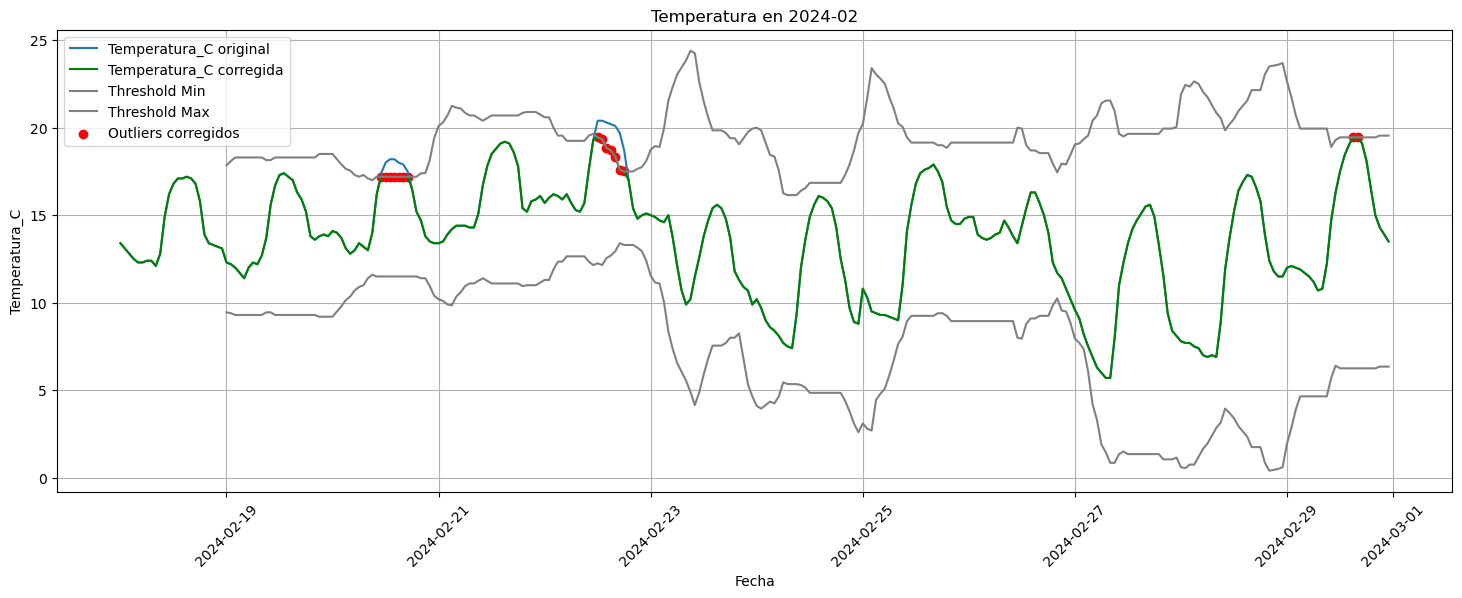

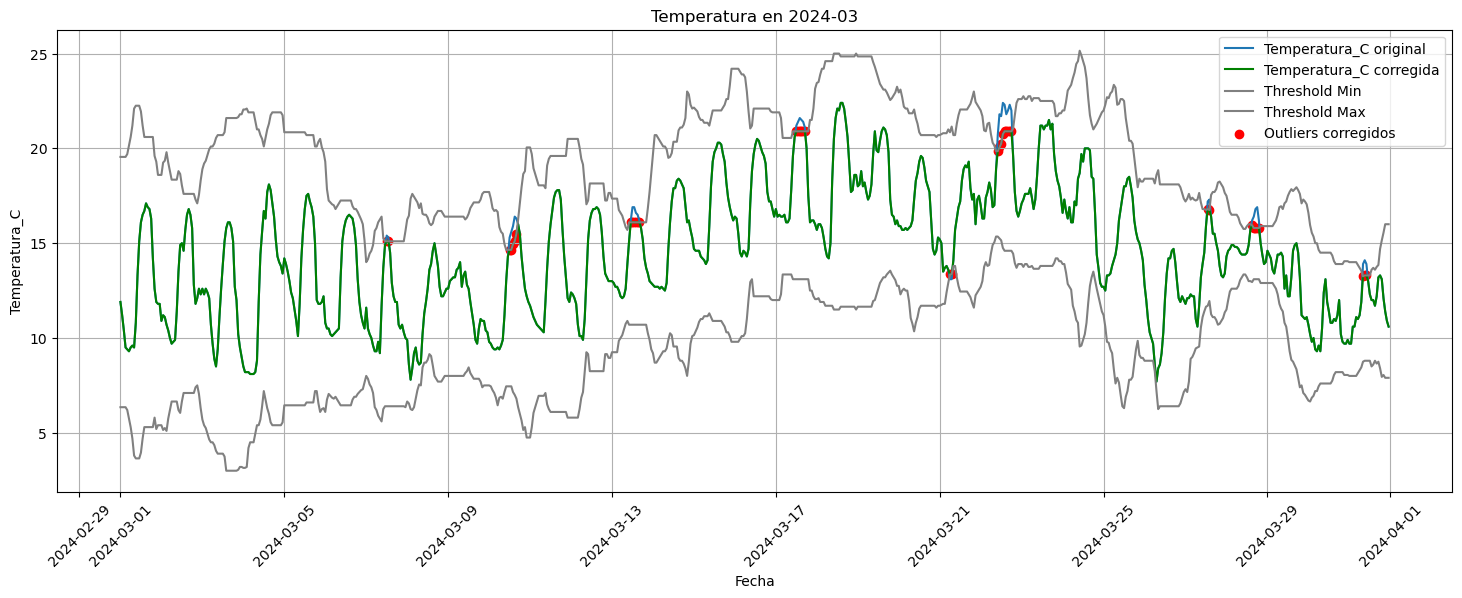

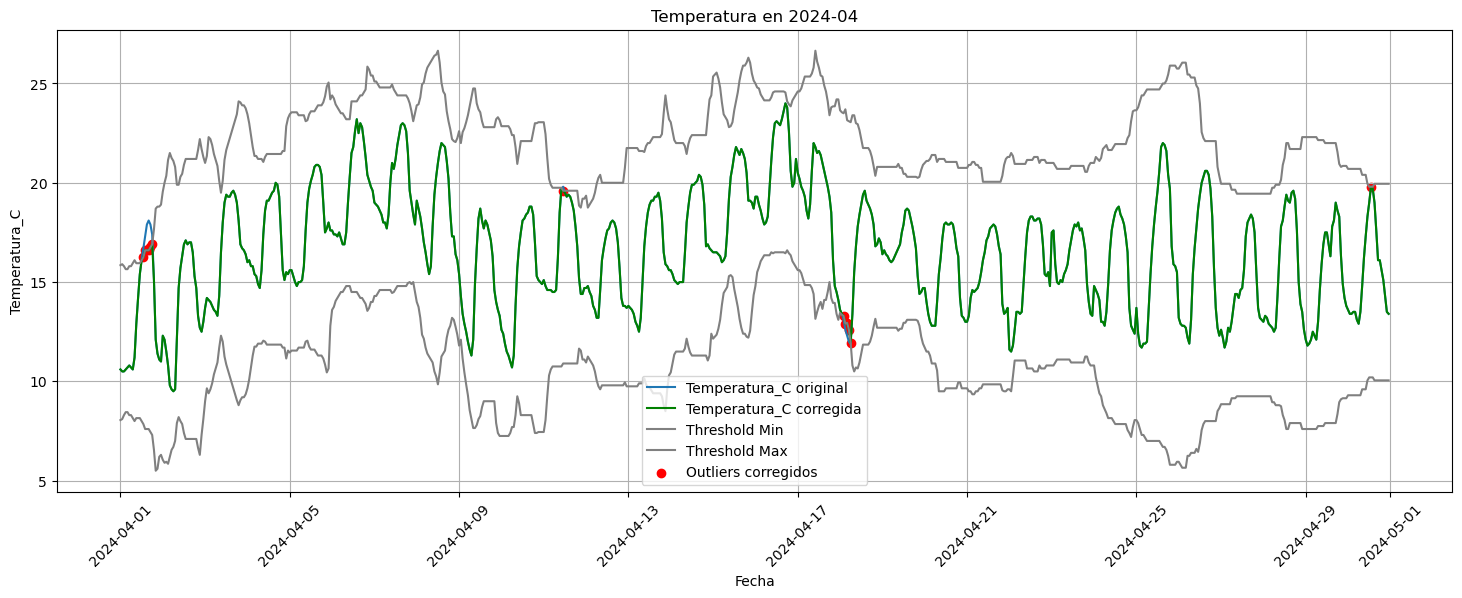

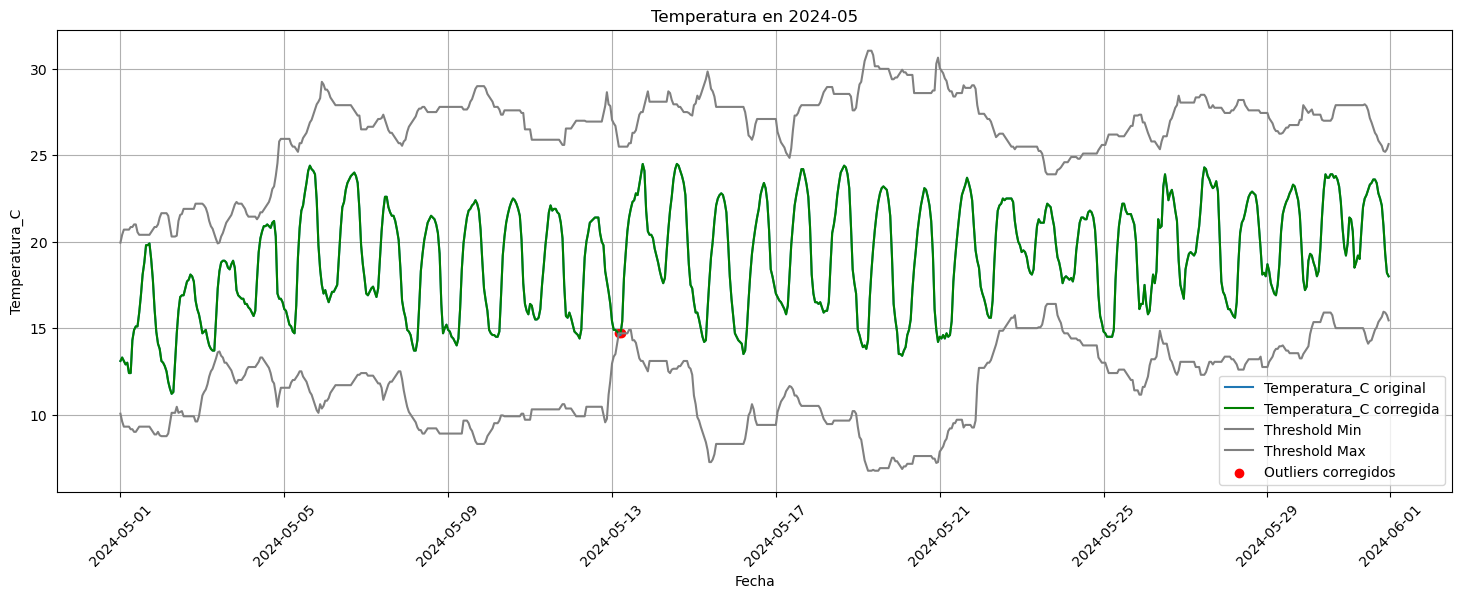

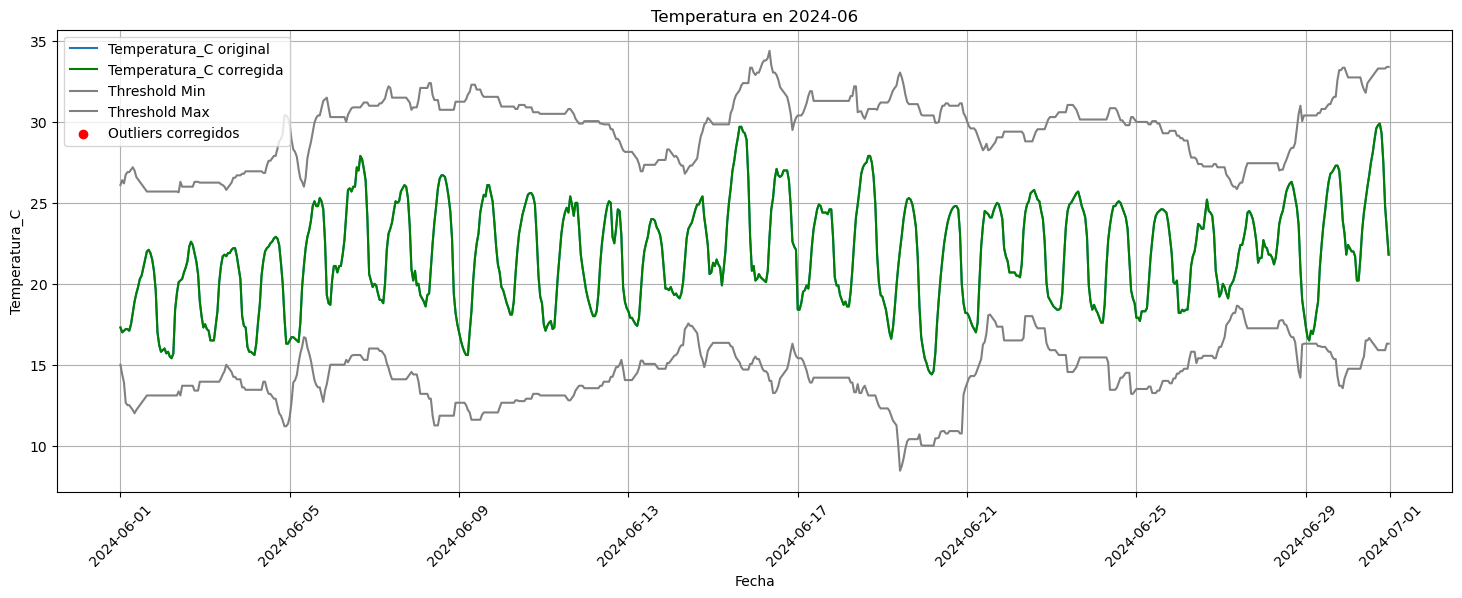

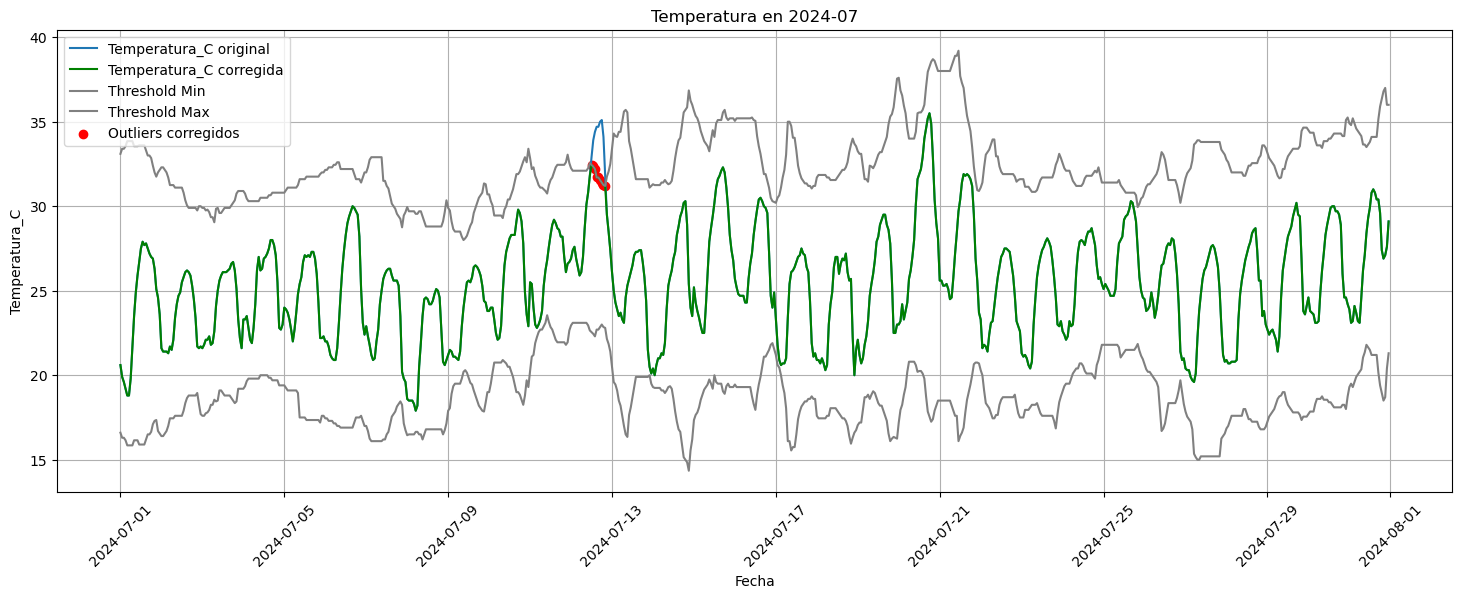

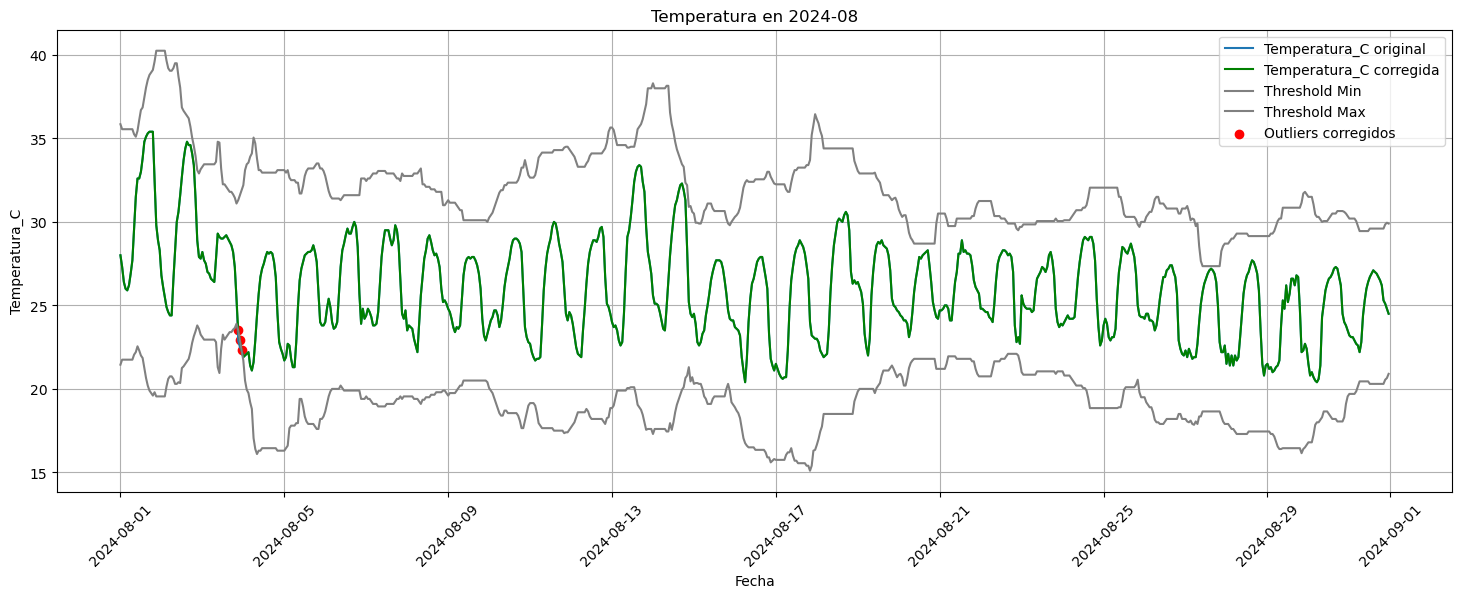

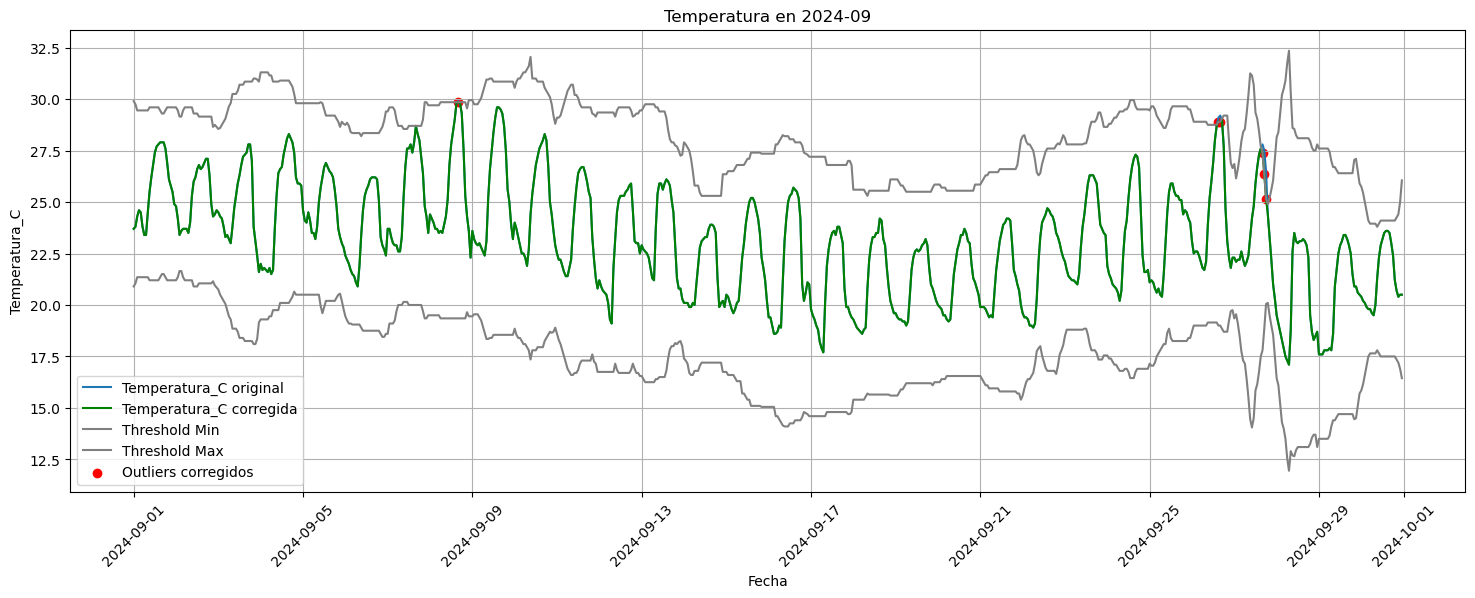

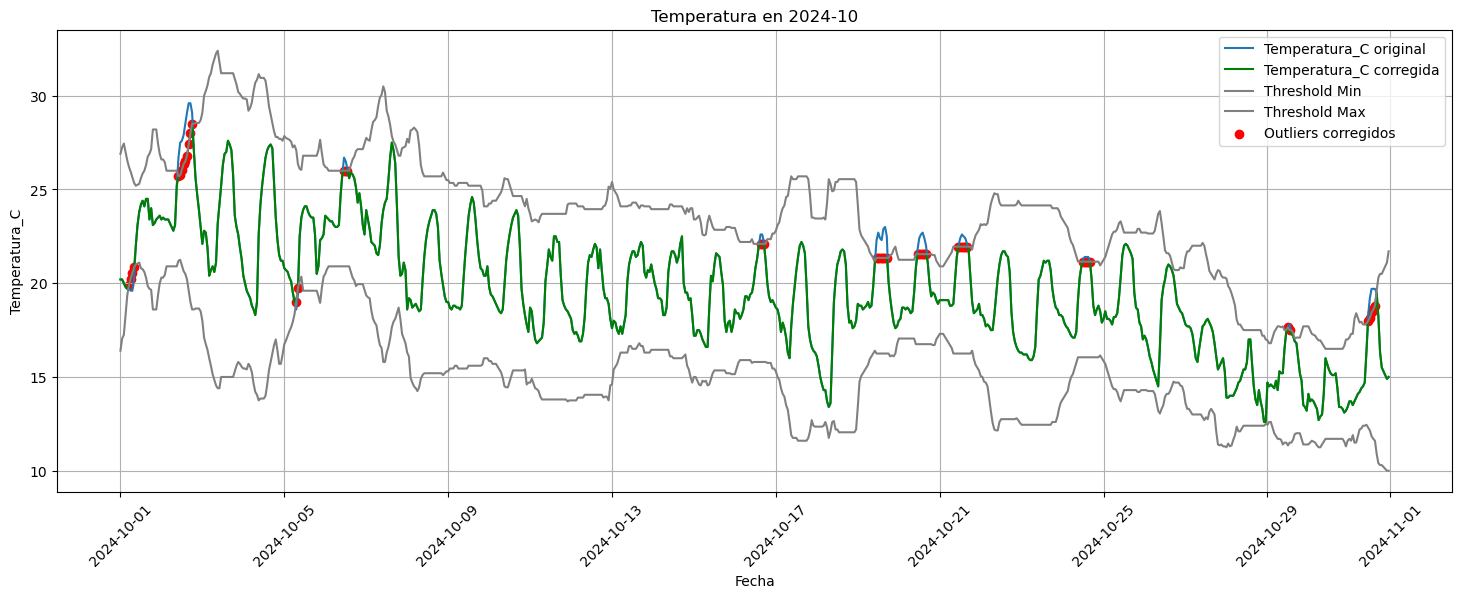

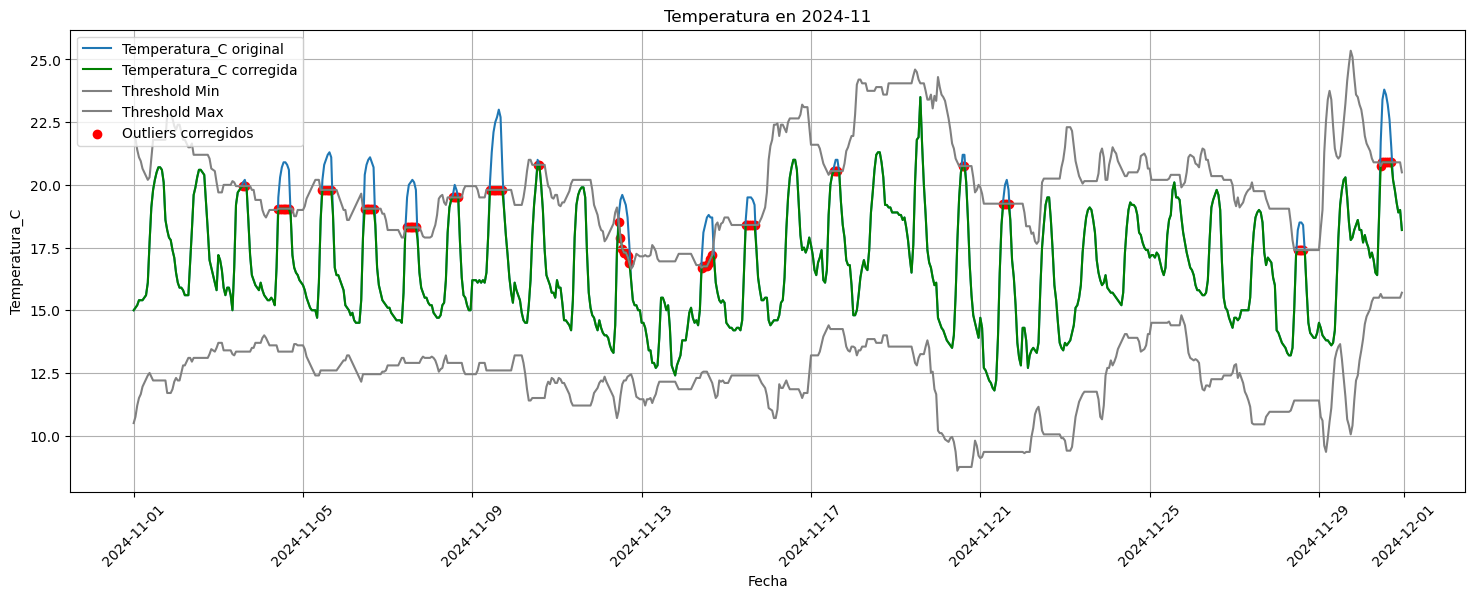

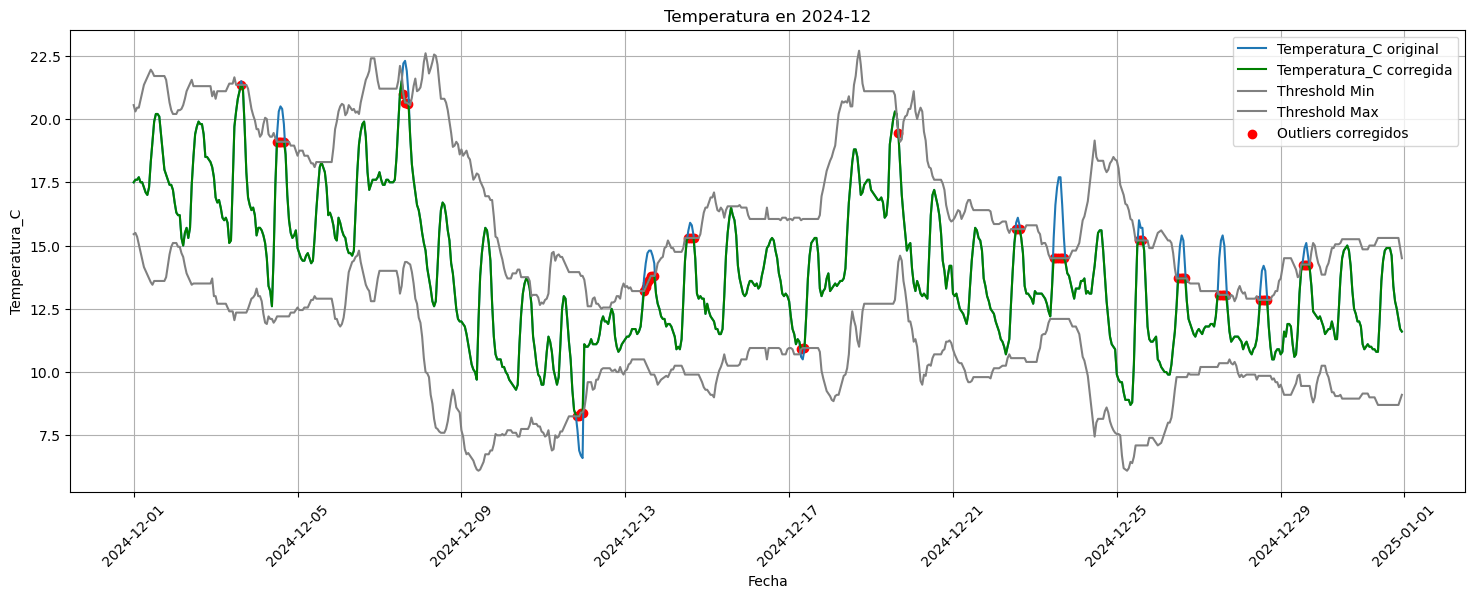

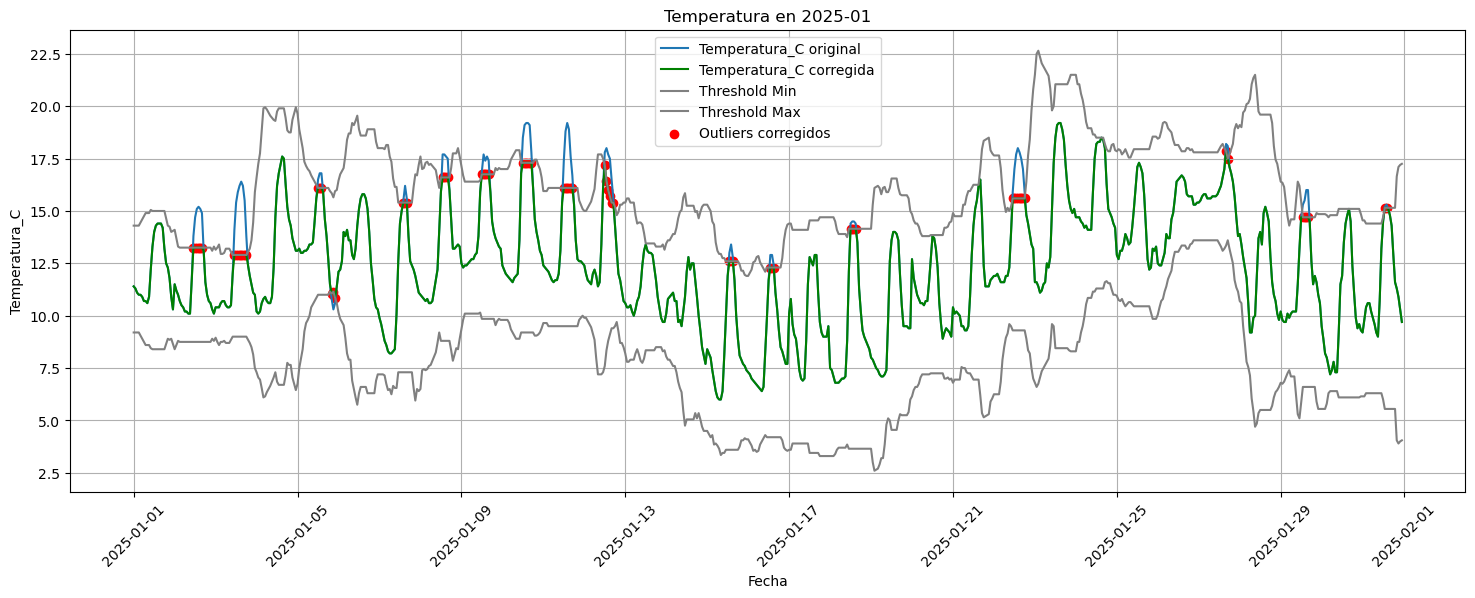

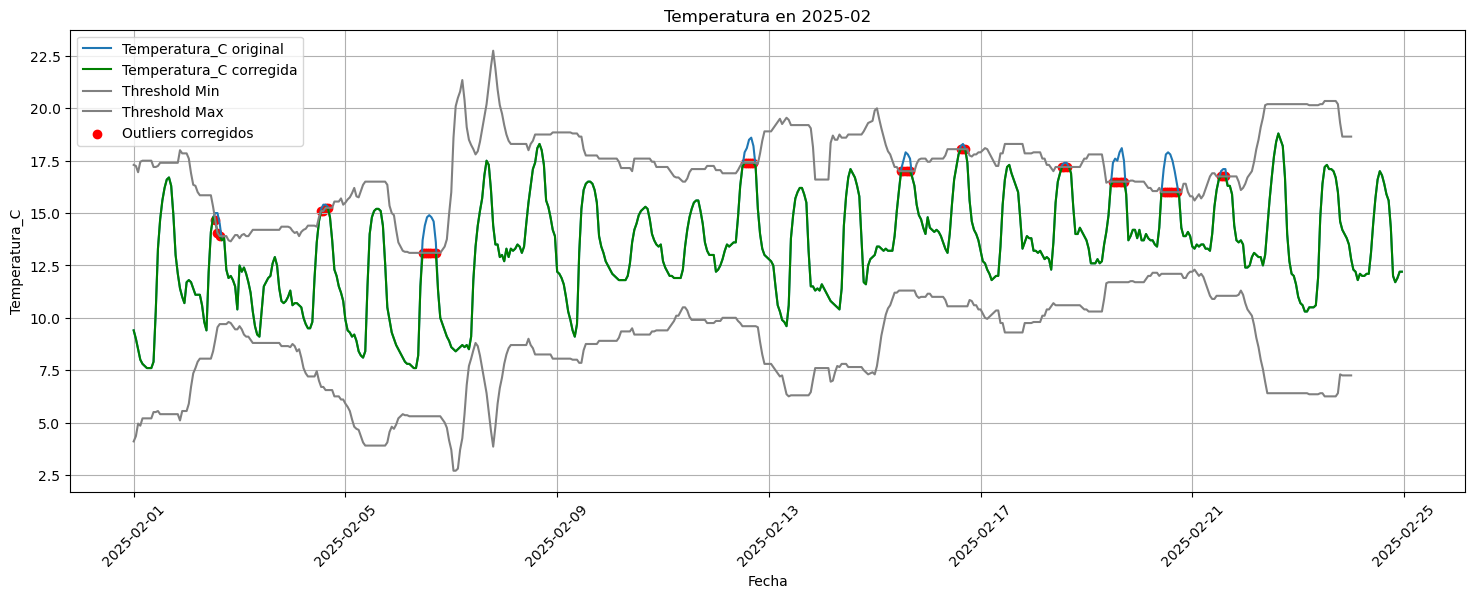

In [53]:
# Iterar sobre cada año-mes único y graficar
for period, df_group in df_pandas.groupby('AñoMes'):
    plt.figure(figsize=(18, 6))
    
    plt.plot(df_group['Fecha'], df_group['Temperatura_C'], label='Temperatura_C original')
    plt.plot(df_group['Fecha'], df_group['t_corrected'], label='Temperatura_C corregida', color='green')
    plt.plot(df_group['Fecha'], threshold_min[df_group.index], color='gray', label='Threshold Min')
    plt.plot(df_group['Fecha'], threshold_max[df_group.index], color='gray', label='Threshold Max')
    plt.scatter(df_group["Fecha"][df_group["outlier_hm"]], df_group["t_corrected"][df_group["outlier_hm"]], color='red', label="Outliers corregidos")
    
    plt.xlabel('Fecha')
    plt.ylabel('Temperatura_C')
    plt.title(f'Temperatura en {period}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


In [54]:
df_pandas

Fecha  Temperatura_C  Sensacion_termica_C  Humedad  \
0    2024-02-18 00:00:00           13.4                 12.4       84   
1    2024-02-18 01:00:00           13.1                 12.2       84   
2    2024-02-18 02:00:00           12.8                 12.0       85   
3    2024-02-18 03:00:00           12.5                 11.6       85   
4    2024-02-18 04:00:00           12.3                 11.5       84   
...                  ...            ...                  ...      ...   
8947 2025-02-24 19:00:00           12.0                 12.3       69   
8948 2025-02-24 20:00:00           11.7                 11.3       70   
8949 2025-02-24 21:00:00           11.9                 11.1       70   
8950 2025-02-24 22:00:00           12.2                 11.4       70   
8951 2025-02-24 23:00:00           12.2                 11.8       69   

      Presion_mb  is_day  Hora         MA  outlier_hm   Año  Mes   AñoMes  \
0         1033.0       0     0        NaN       False  2024    2  2024-02   
1         1033.0       0     1        NaN       False  2024    2  2024-02   
2         1033.0       0     2        NaN       False  2024    2  2024-02   
3         1033.0       0     3        NaN       False  2024    2  2024-02   
4         1032.0       0     4        NaN       False  2024    2  2024-02   
...          ...     ...   ...        ...         ...   ...  ...      ...   
8947      1028.0       1    19  14.178082       False  2025    2  2025-02   
8948      1028.0       0    20  14.164932       False  2025    2  2025-02   
8949      1029.0       0    21  14.152603       False  2025    2  2025-02   
8950      1029.0       0    22  14.141918       False  2025    2  2025-02   
8951      1029.0       0    23  14.132877       False  2025    2  2025-02   

      t_corrected  
0            13.4  
1            13.1  
2            12.8  
3            12.5  
4            12.3  
...           ...  
8947         12.0  
8948         11.7  
8949         11.9  
8950         12.2  
8951         12.2  

[8952 rows x 13 columns]

In [55]:
df_pandas["Temperatura_C"] = df_pandas["t_corrected"]

In [56]:
df_pandas.drop(columns=["MA", "outlier_hm", "t_corrected"], inplace=True)

In [57]:
df_pandas

Fecha  Temperatura_C  Sensacion_termica_C  Humedad  \
0    2024-02-18 00:00:00           13.4                 12.4       84   
1    2024-02-18 01:00:00           13.1                 12.2       84   
2    2024-02-18 02:00:00           12.8                 12.0       85   
3    2024-02-18 03:00:00           12.5                 11.6       85   
4    2024-02-18 04:00:00           12.3                 11.5       84   
...                  ...            ...                  ...      ...   
8947 2025-02-24 19:00:00           12.0                 12.3       69   
8948 2025-02-24 20:00:00           11.7                 11.3       70   
8949 2025-02-24 21:00:00           11.9                 11.1       70   
8950 2025-02-24 22:00:00           12.2                 11.4       70   
8951 2025-02-24 23:00:00           12.2                 11.8       69   

      Presion_mb  is_day  Hora   Año  Mes   AñoMes  
0         1033.0       0     0  2024    2  2024-02  
1         1033.0       0     1  2024    2  2024-02  
2         1033.0       0     2  2024    2  2024-02  
3         1033.0       0     3  2024    2  2024-02  
4         1032.0       0     4  2024    2  2024-02  
...          ...     ...   ...   ...  ...      ...  
8947      1028.0       1    19  2025    2  2025-02  
8948      1028.0       0    20  2025    2  2025-02  
8949      1029.0       0    21  2025    2  2025-02  
8950      1029.0       0    22  2025    2  2025-02  
8951      1029.0       0    23  2025    2  2025-02  

[8952 rows x 10 columns]

Ahora deberemos realizar el mismo estudio para las otras 3 variables que tendremos en consideracion para predecir

Ahora pasaremos a obtener nuevas columnas que aporten informacion al modelo para mejorar las predicciones

In [58]:
df = df_pandas.copy()

In [59]:
# Convertir la columna 'fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Ordenar por fecha
df = df.sort_values('Fecha')

# Verificar que no haya duplicados
df = df.drop_duplicates(subset=['Fecha'])

##### Obtenemos los valores maximo, minimo y media historico para cada fecha 

In [ ]:
# # Crear columnas de estadísticas históricas
# def calcular_estadisticas_diarias(df, columna):
#     # Verifica si la columna existe en el DataFrame
#     if columna not in df.columns:
#         raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

#     # Calcula el máximo, mínimo y media diaria
#     df[f'{columna}_max'] = df.groupby(df['Fecha'].dt.dayofyear)[columna].transform('max')
#     df[f'{columna}_min'] = df.groupby(df['Fecha'].dt.dayofyear)[columna].transform('min')
#     df[f'{columna}_mean'] = df.groupby(df['Fecha'].dt.dayofyear)[columna].transform('mean')

#     return df

In [ ]:
# # Lista de columnas para las cuales se calcularán las estadísticas
# columnas = ['tmed', 'tmin', 'tmax', 'hrMedia']

# # Bucle para aplicar la función a cada columna
# for columna in columnas:
#     df = calcular_estadisticas_diarias(df, columna)

##### Obtenemos la estacion del año para cada fecha

In [61]:
# Crear columna de estación del año
def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    elif month in [9, 10, 11]:
        return 'Otoño'

In [63]:
df['estacion'] = df['Fecha'].dt.month.apply(get_season)

Aplicamos transformacion OHE (One Hot Encoding) para la utilizacion de esta informacion de cara al modelo

In [64]:
# Aplicar get_dummies
df = pd.get_dummies(df, columns=['estacion'])

In [ ]:
# Crear columnas de día de la semana y mes
# df['dia_semana'] = df['fecha'].dt.dayofweek
# df['mes'] = df['fecha'].dt.month

In [ ]:
# Crear columnas de diferencias y variaciones
# df['tmed_diff'] = df['tmed'].diff()
# df['tmed_rolling_mean'] = df['tmed'].rolling(window=7).mean()

In [65]:
df.head(5)

Fecha  Temperatura_C  Sensacion_termica_C  Humedad  \
0 2024-02-18 00:00:00           13.4                 12.4       84   
1 2024-02-18 01:00:00           13.1                 12.2       84   
2 2024-02-18 02:00:00           12.8                 12.0       85   
3 2024-02-18 03:00:00           12.5                 11.6       85   
4 2024-02-18 04:00:00           12.3                 11.5       84   

   Presion_mb  is_day  Hora   Año  Mes   AñoMes  estacion_Invierno  \
0      1033.0       0     0  2024    2  2024-02               True   
1      1033.0       0     1  2024    2  2024-02               True   
2      1033.0       0     2  2024    2  2024-02               True   
3      1033.0       0     3  2024    2  2024-02               True   
4      1032.0       0     4  2024    2  2024-02               True   

   estacion_Otoño  estacion_Primavera  estacion_Verano  
0           False               False            False  
1           False               False            False  
2           False               False            False  
3           False               False            False  
4           False               False            False

In [66]:
df.columns

Index(['Fecha', 'Temperatura_C', 'Sensacion_termica_C', 'Humedad',
       'Presion_mb', 'is_day', 'Hora', 'Año', 'Mes', 'AñoMes',
       'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera',
       'estacion_Verano'],
      dtype='object')

Guardamos el dataframe final preparado para pasar al entrenamiento del modelo

In [67]:
# Guardar el DataFrame limpio en un nuevo archivo CSV (opcional)
ruta_guardado = "/home/jovyan/work/data/homogeneized/df_marbella_hourly.csv"
df.to_csv(ruta_guardado, index=False)

In [68]:
# Detener la sesión de Spark
spark.stop()